In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Actividad Práctica: Introducción a imágenes medicas

## Objetivo

En este ejercicio práctico trabajaremos con el dataset [Structural MRI Datasets](https://www.kaggle.com/datasets/ilknuricke/neurohackinginrimages) en la plataforma Kaggle. Este conjunto de datos incluye imágenes médicas en formato DICOM (Digital Imaging and Communications in Medicine), ampliamente utilizado en entornos clínicos para almacenar estudios como rayos X, resonancias magnéticas y tomografías.

Al finalizar este taller, el estudiante estará en capacitado para:
* Leer imágenes médicas en formato DICOM utilizando pydicom.
* Acceder a metadatos clínicos y técnicos contenidos en la cabecera DICOM.
* Visualizar imágenes en escala de grises y con diferentes mapas de color (cmap).
* Normalizar y manipular las intensidades de la imagen para facilitar su análisis.
* Aplicar una segmentación binaria simple por umbralización.
* Anonimizar imágenes eliminando o sobrescribiendo datos sensibles.
* Exportar imágenes médicas a formatos estándar (PNG, JPG) preservando la información relevante.


## 1. Introducción al dataset

### 1.1 Descripción del dataset

Este conjunto de datos contiene imágenes cerebrales estructurales obtenidas mediante resonancia magnética (MRI), almacenadas en dos formatos comunes: DICOM y NIfTI. Estos formatos permiten tanto la visualización de las imágenes como un análisis más profundo a través de herramientas de procesamiento avanzadas. El dataset es ideal para aquellos interesados en explorar técnicas de visualización, segmentación, y análisis cuantitativo en neurociencia computacional, especialmente en el contexto de estudios clínicos y de investigación.

#### DICOM (Digital Imaging and Communications in Medicine)

Este es el formato estándar para el almacenamiento y transmisión de imágenes médicas en el ámbito clínico. Los archivos DICOM contienen no solo la imagen en sí, sino también una gran cantidad de metadatos asociados, incluyendo:

- Parámetros técnicos de adquisición (ej. resolución, grosor de corte)  
- Identificadores del paciente (anonimizados en este caso)  
- Fecha y hora del estudio  
- Modalidad de la imagen (ej. T1, T2, FLAIR)  
- Información del dispositivo de escaneo  

En este dataset, las imágenes DICOM están organizadas según su modalidad dentro de subdirectorios:

- **T1, T2, FLAIR**: diferentes secuencias de imagen utilizadas para resaltar distintas características anatómicas.  
- **ROI**: máscaras de regiones de interés generadas manualmente o automáticamente.  

---

#### NIfTI (Neuroimaging Informatics Technology Initiative)

Este es un formato comúnmente utilizado para el análisis e investigación con imágenes médicas. Es especialmente útil en contextos computacionales y cuantitativos, ya que:

- Contiene la imagen en una estructura 3D o 4D  
- Incluye información espacial como la orientación anatómica y el tamaño del voxel  
- Es fácilmente manipulable en software de análisis de imágenes médicas como FSL, ANTs, SPM, o usando librerías como `nibabel` en Python  

Las imágenes en formato NIfTI (.nii o .nii.gz) permiten operaciones como:

- Visualización tridimensional  
- Registro entre imágenes  
- Segmentación de estructuras  
- Extracción de métricas volumétricas o de intensidad  

---

En resumen, el dataset proporciona imágenes médicas estructurales en formatos DICOM y NIfTI, lo que permite tanto la exploración visual de los datos originales como el análisis computacional.

Al descomprimir el archivo ZIP del dataset, se obtiene una estructura de carpetas que incluye múltiples tipos de imágenes estructurales cerebrales. El contenido se organiza de la siguiente manera:

```
BRAINIX
    ├── DICOM
    │   ├── FLAIR
    │   ├── ROI
    │   ├── T1
    │   └── T2
    └── NIFTI

```

### 1.2 Acceso al dataset

Al igual que el taller anterior, el acceso al dataset se realiza a través de la plataforma Kaggle


In [ ]:
#!rm -rf Neurohacking_data-0.0/
#!rm -rf __MACOSX/
#!rm -rf mri_old/
#!rm -rf sample_data/

In [1]:
!ls

Datos
osic-pulmonary-fibrosis-progression.zip
TALLER_4_DIADM_Analisis_de_Imagenes.ipynb
TALLER_4_DIADM_Analisis_de_Imagenes_versionCami.ipynb


In [2]:
import kagglehub
import os

# Download latest version
folder = kagglehub.dataset_download("ilknuricke/neurohackinginrimages", force_download=True)

print("Ruta a la carpeta:", folder)

!ln -s {folder} ./mri
!unzip -o mri/Neurohacking_data-0.0.zip

ModuleNotFoundError: No module named 'kagglehub'

> El símbolo ! en Google Colab (y notebooks en general) permite ejecutar comandos de consola (shell/bash) directamente desde una celda de Python.
> Por ejemplo:
> - !ln -s ... crea un enlace simbólico (acceso directo) a una carpeta.
> - !unzip ... descomprime archivos ZIP usando la utilidad del sistema.
## 2. PyDICOM

[PyDICOM](https://pydicom.github.io/) es una de las librerías más populares para trabajar con archivos DICOM en Python. Con PyDICOM puedes:

* **Cargar archivos DICOM desde un directorio.** :Esto permite leer de forma sencilla cualquier archivo DICOM para luego extraer su contenido.

* **Acceder a los metadatos de la cabecera DICOM.** : La cabecera DICOM contiene información importante (como Patient ID, Patient Age, Modality, etc.) que se puede utilizar para identificar o clasificar las imágenes. PyDICOM facilita la extracción de estos atributos.

* **Modificar los campos de metadatos si es necesario.**: Esto es especialmente útil para la anonimización, ya que puedes sobrescribir o eliminar la información sensible del paciente.

### 2.1 Instalación de PyDICOM
Para instalar PyDICOM, puedes ejecutar el siguiente comando en tu terminal o en una celda de Jupyter:
  
    !pip install pydicom
  
Una vez instalada, podrás utilizar sus funciones para cargar y manipular archivos DICOM.

## 3. Importar librerías necesarias





In [ ]:
!pip install pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 60.9 MB/s eta 0:00:00


In [ ]:
import pydicom
import numpy as np
import matplotlib.pyplot as plt

## 4. Trabajando con imagenes DICOM


### 4.1 Trabajando con multiples archivos
Para listar los archivos DICOM en un directorio específico, puede usar la librería `os` de Python. Esto te permitirá ver qué archivos están disponibles para su procesamiento.

#### **Ejercicio 1**
En este primer ejercicio, se le pide que enumere todos los archivos DICOM (extensión .dcm) presentes en la carpeta  `Neurohacking_data-0.0/BRAINIX/DICOM/` para T1 y T2. Al listar sus nombres, podrá confirmar cuántos archivos hay y tener una visión inicial de los datos disponibles. HINT: Los archivos DICOM tienen la extensión `.dcm`. Puedes usar `os.listdir()` para listar los archivos en un directorio y luego filtrar por estas extensiones.


In [ ]:
# <CODE> utilice listdir aquí para poder acceder a los nombres de las carpetas para T1
T1_path_dicom = 'Neurohacking_data-0.0/BRAINIX/DICOM/T1'
files = os.listdir(T1_path_dicom)
files

['BRAINIX_DICOM_T1_IM-0001-0012.dcm',
 'BRAINIX_DICOM_T1_IM-0001-0020.dcm',
 'BRAINIX_DICOM_T1_IM-0001-0022.dcm',
 'BRAINIX_DICOM_T1_IM-0001-0003.dcm',
 'BRAINIX_DICOM_T1_IM-0001-0018.dcm',
 'BRAINIX_DICOM_T1_IM-0001-0001.dcm',
 'BRAINIX_DICOM_T1_IM-0001-0011.dcm',
 'BRAINIX_DICOM_T1_IM-0001-0015.dcm',
 'BRAINIX_DICOM_T1_IM-0001-0002.dcm',
 'BRAINIX_DICOM_T1_IM-0001-0016.dcm',
 'BRAINIX_DICOM_T1_IM-0001-0014.dcm',
 '.DS_Store',
 'BRAINIX_DICOM_T1_IM-0001-0013.dcm',
 'BRAINIX_DICOM_T1_IM-0001-0008.dcm',
 'BRAINIX_DICOM_T1_IM-0001-0004.dcm',
 'BRAINIX_DICOM_T1_IM-0001-0019.dcm',
 'BRAINIX_DICOM_T1_IM-0001-0006.dcm',
 'BRAINIX_DICOM_T1_IM-0001-0010.dcm',
 'BRAINIX_DICOM_T1_IM-0001-0017.dcm',
 'BRAINIX_DICOM_T1_IM-0001-0021.dcm',
 'BRAINIX_DICOM_T1_IM-0001-0009.dcm',
 'BRAINIX_DICOM_T1_IM-0001-0007.dcm',
 'BRAINIX_DICOM_T1_IM-0001-0005.dcm']

In [ ]:
T1_dicom_files = []
for file in files:
  if file.endswith('.dcm'):
    T1_dicom_files.append(file)
T1_dicom_files

['BRAINIX_DICOM_T1_IM-0001-0012.dcm',
 'BRAINIX_DICOM_T1_IM-0001-0020.dcm',
 'BRAINIX_DICOM_T1_IM-0001-0022.dcm',
 'BRAINIX_DICOM_T1_IM-0001-0003.dcm',
 'BRAINIX_DICOM_T1_IM-0001-0018.dcm',
 'BRAINIX_DICOM_T1_IM-0001-0001.dcm',
 'BRAINIX_DICOM_T1_IM-0001-0011.dcm',
 'BRAINIX_DICOM_T1_IM-0001-0015.dcm',
 'BRAINIX_DICOM_T1_IM-0001-0002.dcm',
 'BRAINIX_DICOM_T1_IM-0001-0016.dcm',
 'BRAINIX_DICOM_T1_IM-0001-0014.dcm',
 'BRAINIX_DICOM_T1_IM-0001-0013.dcm',
 'BRAINIX_DICOM_T1_IM-0001-0008.dcm',
 'BRAINIX_DICOM_T1_IM-0001-0004.dcm',
 'BRAINIX_DICOM_T1_IM-0001-0019.dcm',
 'BRAINIX_DICOM_T1_IM-0001-0006.dcm',
 'BRAINIX_DICOM_T1_IM-0001-0010.dcm',
 'BRAINIX_DICOM_T1_IM-0001-0017.dcm',
 'BRAINIX_DICOM_T1_IM-0001-0021.dcm',
 'BRAINIX_DICOM_T1_IM-0001-0009.dcm',
 'BRAINIX_DICOM_T1_IM-0001-0007.dcm',
 'BRAINIX_DICOM_T1_IM-0001-0005.dcm']

In [ ]:
len(T1_dicom_files)

22

In [ ]:
# <CODE> utilice listdir aquí para poder acceder a los nombres de las carpetas para T2
T2_path_dicom = 'Neurohacking_data-0.0/BRAINIX/DICOM/T2'
files = os.listdir(T2_path_dicom)
files

['BRAINIX_DICOM_T2_IM-0001-0014.dcm',
 'BRAINIX_DICOM_T2_IM-0001-0015.dcm',
 'BRAINIX_DICOM_T2_IM-0001-0012.dcm',
 'BRAINIX_DICOM_T2_IM-0001-0009.dcm',
 'BRAINIX_DICOM_T2_IM-0001-0005.dcm',
 'BRAINIX_DICOM_T2_IM-0001-0001.dcm',
 'BRAINIX_DICOM_T2_IM-0001-0007.dcm',
 'BRAINIX_DICOM_T2_IM-0001-0008.dcm',
 'BRAINIX_DICOM_T2_IM-0001-0003.dcm',
 '.DS_Store',
 'BRAINIX_DICOM_T2_IM-0001-0016.dcm',
 'BRAINIX_DICOM_T2_IM-0001-0018.dcm',
 'BRAINIX_DICOM_T2_IM-0001-0020.dcm',
 'BRAINIX_DICOM_T2_IM-0001-0022.dcm',
 'BRAINIX_DICOM_T2_IM-0001-0002.dcm',
 'BRAINIX_DICOM_T2_IM-0001-0021.dcm',
 'BRAINIX_DICOM_T2_IM-0001-0019.dcm',
 'BRAINIX_DICOM_T2_IM-0001-0017.dcm',
 'BRAINIX_DICOM_T2_IM-0001-0010.dcm',
 'BRAINIX_DICOM_T2_IM-0001-0006.dcm',
 'BRAINIX_DICOM_T2_IM-0001-0004.dcm',
 'BRAINIX_DICOM_T2_IM-0001-0013.dcm',
 'BRAINIX_DICOM_T2_IM-0001-0011.dcm']

In [ ]:
T2_dicom_files = []
for file in files:
  if file.endswith('.dcm'):
    T2_dicom_files.append(file)
T2_dicom_files

['BRAINIX_DICOM_T2_IM-0001-0014.dcm',
 'BRAINIX_DICOM_T2_IM-0001-0015.dcm',
 'BRAINIX_DICOM_T2_IM-0001-0012.dcm',
 'BRAINIX_DICOM_T2_IM-0001-0009.dcm',
 'BRAINIX_DICOM_T2_IM-0001-0005.dcm',
 'BRAINIX_DICOM_T2_IM-0001-0001.dcm',
 'BRAINIX_DICOM_T2_IM-0001-0007.dcm',
 'BRAINIX_DICOM_T2_IM-0001-0008.dcm',
 'BRAINIX_DICOM_T2_IM-0001-0003.dcm',
 'BRAINIX_DICOM_T2_IM-0001-0016.dcm',
 'BRAINIX_DICOM_T2_IM-0001-0018.dcm',
 'BRAINIX_DICOM_T2_IM-0001-0020.dcm',
 'BRAINIX_DICOM_T2_IM-0001-0022.dcm',
 'BRAINIX_DICOM_T2_IM-0001-0002.dcm',
 'BRAINIX_DICOM_T2_IM-0001-0021.dcm',
 'BRAINIX_DICOM_T2_IM-0001-0019.dcm',
 'BRAINIX_DICOM_T2_IM-0001-0017.dcm',
 'BRAINIX_DICOM_T2_IM-0001-0010.dcm',
 'BRAINIX_DICOM_T2_IM-0001-0006.dcm',
 'BRAINIX_DICOM_T2_IM-0001-0004.dcm',
 'BRAINIX_DICOM_T2_IM-0001-0013.dcm',
 'BRAINIX_DICOM_T2_IM-0001-0011.dcm']

In [ ]:
len(T2_dicom_files)

22


### 4.2 Carga de archivos dicom
En este ejercicio se le pedirá cargar una imagen T1. Primero necesitará importar la librería `pydicom` y luego usar la función `dcmread()` para leer el archivo. Debe asegurarse de que el archivo DICOM esté en el directorio correcto.

```python
import pydicom

# Cargar un archivo DICOM
dicom_file = pydicom.dcmread('ruta/al/archivo.dcm')
```
#### **Ejercicio 2**


En este ejercicio, debe cargar el primer archivo DICOM de la carpeta T1 y T2. Para ello, puede usar la función `dcmread()` de la librería `pydicom`. Debe asegurarse de que el archivo esté en el directorio correcto. Desarrolle el codigo de modo que sea capaz de cargar cualquier archivo DICOM, cambiando el indice del archivo.



In [ ]:
# <CODE> cargue archivos dicom para  T1
path = T1_path_dicom +'/'+ T1_dicom_files[0]
path

'Neurohacking_data-0.0/BRAINIX/DICOM/T1/BRAINIX_DICOM_T1_IM-0001-0012.dcm'

In [ ]:
T1 = pydicom.dcmread(path)
T1

Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 210
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: MR Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 1.3.46.670589.11.0.0.11.4.2.0.8743.5.5396.2006120114375154611
(0002,0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002,0012) Implementation Class UID            UI: 1.2.276.0.7238010.5.0.3.5.4
(0002,0013) Implementation Version Name         SH: 'OSIRIX'
(0002,0016) Source Application Entity Title     AE: 'OSIRIX'
-------------------------------------------------
(0008,0005) Specific Character Set              CS: 'ISO_IR 100'
(0008,0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'M_SE', 'M', 'SE']
(0008,0012) Instance Creation Date              DA: '20061201'
(0008,0013) Instance Creation Time              TM: '145331.000000'
(0008,0014) Instance Creat

In [ ]:
imagen_T1 = T1.pixel_array
imagen_T1.shape

(512, 512)

In [ ]:
# <CODE> cargue archivos dicom para  T2
path = T2_path_dicom +'/'+ T2_dicom_files[0]
T2 = pydicom.dcmread(path)
imagen_T2 = T2.pixel_array
imagen_T2.shape

(512, 512)

## 4.3 Exploración de metadatos

#### **Ejercicio 3**

Revise la cabecera del archivo DCM cargado, para conocer datos como nombre del paciente, modalidad de la imagen, fecha de estudio, tamaño, pixel spacing y protocolo de adquisición. Identifique cuál de estos campos podría considerarse sensible. Puede explorar el header del archivo DICOM con el siguiente comando:
```python
print(dicom_file)
```
o
```python
dicom_file[0x0010, 0x0010].value  # nombre del paciente
```
Donde `0x0010, 0x0010` es el tag del nombre del paciente. Puede encontrar una lista de tags DICOM en la [documentación oficial](https://dicom.innolitics.com/ciods/part10/sect6.2).




In [ ]:
# <CODE> Analice la información en la cabecera dicom de las imágenes de T1 y T2
# PatientName, PatientID, Modality, StudyDate, ProtocolName, Rows, Columns, PixelSpacing
print('Nombre del paciente:',T1.get('PatientName','Desconocido'), T1.PatientName, T1[0x0010,0x0010].value)
print('ID del paciente:',T1.get('PatientID','Desconocido'), T1.PatientID, T1[0x0010,0x0020].value)
print('Modalidad:',T1.get('Modality','Desconocido'), T1.Modality, T1[0x0008, 0x0060].value)
print('Fecha del estudio:',T1.get('StudyDate','Desconocido'), T1.StudyDate, T1[0x0008, 0x0020].value)
print('Protocolo:',T1.get('ProtocolName','Desconocido'), T1.ProtocolName)
print('Tamaño:',T1.get('Rows','Desconocido'), T1.Rows, T1.get('Columns','Desconocido'), T1.Columns)
print('Pixel Spacing:',T1.get('PixelSpacing','Desconocido'), T1.PixelSpacing)

Nombre del paciente: BRAINIX BRAINIX BRAINIX
ID del paciente: 5Yp0E 5Yp0E 5Yp0E
Modalidad: MR MR MR
Fecha del estudio: 20061201 20061201 20061201
Protocolo: T1/SE/extrp CLEAR T1/SE/extrp CLEAR
Tamaño: 512 512 512 512
Pixel Spacing: [0.46875, 0.46875] [0.46875, 0.46875]


#### **Ejercicio 4**

Para consolidar la información obtenida, recorra todos los archivos .dcm T1 y T2. Extraiga información clave (por ejemplo, modalidad, tamaño de la imagen y fecha del estudio). Almacene estos datos en un DataFrame de pandas que le permita manejar la información de forma tabular.


In [ ]:
# <CODE> Recorra todas las imagenes y genere el data frame para los valores que
# se solicitan.

import pandas as pd

info_list = []
for file in T1_dicom_files:
  path = T1_path_dicom +'/'+ file
  ds_temp = pydicom.dcmread(path)

  file_info = {
      'file_name':file,
      'modality': ds_temp.Modality,
      'rows': ds_temp.Rows,
      'columns': ds_temp.Columns,
      'study_date': ds_temp.StudyDate,
      'sequence_name': ds_temp[0x0018,0x0020].value,
      'protocol_name': ds_temp.ProtocolName,
      'patient_name': ds_temp.PatientName,
      'patient_id': ds_temp.PatientID,
  }
  info_list.append(file_info)

df_info_T1 = pd.DataFrame(info_list)
df_info_T1



,file_name,modality,rows,columns,study_date,sequence_name,protocol_name,patient_name,patient_id
0,BRAINIX_DICOM_T1_IM-0001-0012.dcm,MR,512,512,20061201,SE,T1/SE/extrp CLEAR,"(B, R, A, I, N, I, X)",5Yp0E
1,BRAINIX_DICOM_T1_IM-0001-0020.dcm,MR,512,512,20061201,SE,T1/SE/extrp CLEAR,"(B, R, A, I, N, I, X)",5Yp0E
2,BRAINIX_DICOM_T1_IM-0001-0022.dcm,MR,512,512,20061201,SE,T1/SE/extrp CLEAR,"(B, R, A, I, N, I, X)",5Yp0E
3,BRAINIX_DICOM_T1_IM-0001-0003.dcm,MR,512,512,20061201,SE,T1/SE/extrp CLEAR,"(B, R, A, I, N, I, X)",5Yp0E
4,BRAINIX_DICOM_T1_IM-0001-0018.dcm,MR,512,512,20061201,SE,T1/SE/extrp CLEAR,"(B, R, A, I, N, I, X)",5Yp0E
5,BRAINIX_DICOM_T1_IM-0001-0001.dcm,MR,512,512,20061201,SE,T1/SE/extrp CLEAR,"(B, R, A, I, N, I, X)",5Yp0E
6,BRAINIX_DICOM_T1_IM-0001-0011.dcm,MR,512,512,20061201,SE,T1/SE/extrp CLEAR,"(B, R, A, I, N, I, X)",5Yp0E
7,BRAINIX_DICOM_T1_IM-0001-0015.dcm,MR,512,512,20061201,SE,T1/SE/extrp CLEAR,"(B, R, A, I, N, I, X)",5Yp0E
8,BRAINIX_DICOM_T1_IM-0001-0002.dcm,MR,512,512,20061201,SE,T1/SE/extrp CLEAR,"(B, R, A, I, N, I, X)",5Yp0E
9,BRAINIX_DICOM_T1_IM-0001-0016.dcm,MR,512,512,20061201,SE,T1/SE/extrp CLEAR,"(B, R, A, I, N, I, X)",5Yp0E


In [ ]:
info_list = []
for file in T2_dicom_files:
  path = T2_path_dicom +'/'+ file
  ds_temp = pydicom.dcmread(path)

  file_info = {
      'file_name':file,
      'modality': ds_temp.Modality,
      'rows': ds_temp.Rows,
      'columns': ds_temp.Columns,
      'study_date': ds_temp.StudyDate,
      'sequence_name': ds_temp[0x0018,0x0020].value,
      'protocol_name': ds_temp.ProtocolName,
      'patient_name': ds_temp.PatientName,
      'patient_id': ds_temp.PatientID,
  }
  info_list.append(file_info)

df_info_T2 = pd.DataFrame(info_list)
df_info_T2



,file_name,modality,rows,columns,study_date,sequence_name,protocol_name,patient_name,patient_id
0,BRAINIX_DICOM_T2_IM-0001-0014.dcm,MR,512,512,20061201,SE,sT2/TSE/T SENSE,"(B, R, A, I, N, I, X)",5Yp0E
1,BRAINIX_DICOM_T2_IM-0001-0015.dcm,MR,512,512,20061201,SE,sT2/TSE/T SENSE,"(B, R, A, I, N, I, X)",5Yp0E
2,BRAINIX_DICOM_T2_IM-0001-0012.dcm,MR,512,512,20061201,SE,sT2/TSE/T SENSE,"(B, R, A, I, N, I, X)",5Yp0E
3,BRAINIX_DICOM_T2_IM-0001-0009.dcm,MR,512,512,20061201,SE,sT2/TSE/T SENSE,"(B, R, A, I, N, I, X)",5Yp0E
4,BRAINIX_DICOM_T2_IM-0001-0005.dcm,MR,512,512,20061201,SE,sT2/TSE/T SENSE,"(B, R, A, I, N, I, X)",5Yp0E
5,BRAINIX_DICOM_T2_IM-0001-0001.dcm,MR,512,512,20061201,SE,sT2/TSE/T SENSE,"(B, R, A, I, N, I, X)",5Yp0E
6,BRAINIX_DICOM_T2_IM-0001-0007.dcm,MR,512,512,20061201,SE,sT2/TSE/T SENSE,"(B, R, A, I, N, I, X)",5Yp0E
7,BRAINIX_DICOM_T2_IM-0001-0008.dcm,MR,512,512,20061201,SE,sT2/TSE/T SENSE,"(B, R, A, I, N, I, X)",5Yp0E
8,BRAINIX_DICOM_T2_IM-0001-0003.dcm,MR,512,512,20061201,SE,sT2/TSE/T SENSE,"(B, R, A, I, N, I, X)",5Yp0E
9,BRAINIX_DICOM_T2_IM-0001-0016.dcm,MR,512,512,20061201,SE,sT2/TSE/T SENSE,"(B, R, A, I, N, I, X)",5Yp0E


## 5. Visualización de imágenes DICOM
Para visualizar imágenes DICOM, puede usar la librería `matplotlib`. Debe asegurarse de que la imagen esté en formato de matriz NumPy antes de intentar mostrarla. Puede usar `dicom_file.pixel_array` para acceder a la matriz de píxeles.

#### **Ejercicio 5**
Visualice la imagen DICOM cargada en el ejercicio 2. Asegurese  de que la imagen se muestre correctamente y ajuste el mapa de color (cmap) si es necesario. Puede usar `plt.imshow()` para mostrar la imagen y `plt.axis('off')` para ocultar los ejes.




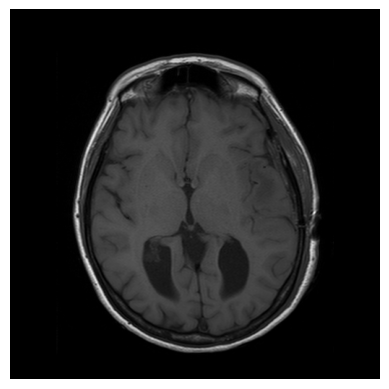

In [ ]:
# <CODE> Muestre una imagen DICOM
IMG_T1 = T1.pixel_array

fig, ax = plt.subplots()
ax.imshow(IMG_T1, cmap='gray')
ax.axis('off')
plt.show()

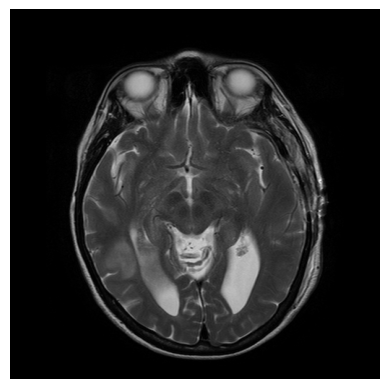

In [ ]:
IMG_T2 = T2.pixel_array

fig, ax = plt.subplots()
ax.imshow(IMG_T2, cmap='gray')
ax.axis('off')
plt.show()

### 5.1 Mapa de color

Un mapa de color (cmap) es una representación visual que asigna colores a diferentes valores de intensidad en una imagen. En el contexto de imágenes médicas, los mapas de color pueden ayudar a resaltar características específicas de la imagen, facilitando su interpretación.
Los mapas de color son especialmente útiles en imágenes en escala de grises, donde los valores de intensidad pueden no ser fácilmente interpretables. Al aplicar un cmap, puede transformar la imagen en una representación más intuitiva y visualmente atractiva.

Para aplicar un cmap a una imagen, puede usar la función `imshow(cmap='cmap')` de `matplotlib` y especificar el cmap deseado. Algunos cmap comunes son:
- `gray`: Escala de grises
- `hot`: Mapa de calor
- `jet`: Mapa de colores en espectro
- `viridis`: Mapa de colores perceptualmente uniforme
- `plasma`: Mapa de colores perceptualmente uniforme


#### **Ejercicio 6**
Aplique diferentes mapas de color a la imagen DICOM cargada en el ejercicio 2. Experimente con al menos tres cmap diferentes y observe cómo cambia la visualización de la imagen. Puedes usar `plt.imshow()` para mostrar la imagen y `plt.axis('off')` para ocultar los ejes.


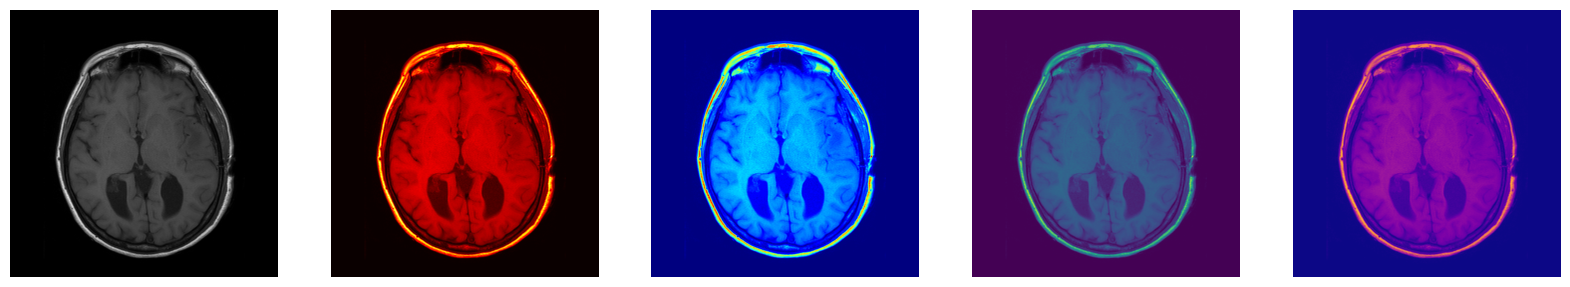

In [ ]:
# <CODE> Muestre una imagen DICOM con distinos mapas de colores
IMG_T1 = T1.pixel_array

fig, ax = plt.subplots(1,5, figsize = (20,5))
ax[0].imshow(IMG_T1, cmap='gray')
ax[0].axis('off')

ax[1].imshow(IMG_T1, cmap='hot')
ax[1].axis('off')

ax[2].imshow(IMG_T1, cmap='jet')
ax[2].axis('off')

ax[3].imshow(IMG_T1, cmap='viridis')
ax[3].axis('off')

ax[4].imshow(IMG_T1, cmap='plasma')
ax[4].axis('off')
plt.show()

### 5.2 Visualización de multiple imágenes

Para visualizar múltiples imágenes DICOM en una sola figura, puede usar subgráficas (subplots) de `matplotlib`. Esto es útil para comparar diferentes imágenes o diferentes cortes de la misma imagen. La sintaxis básica para crear subgráficas es la siguiente:


```python
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)  # Fila 1, Columna 1
plt.imshow(image1, cmap='gray')
plt.axis('off')
plt.subplot(2, 2, 2)  # Fila 1, Columna 2
plt.imshow(image2, cmap='gray')
plt.axis('off')
plt.subplot(2, 2, 3)  # Fila 2, Columna 1
plt.imshow(image3, cmap='gray')
plt.axis('off')
plt.subplot(2, 2, 4)  # Fila 2, Columna 2
plt.imshow(image4, cmap='gray')
plt.axis('off')
plt.show()


```

O otra alternativa es la siguiente

```python
fig, ax = plt.subplots(2,2,figsize=(10, 10))
ax[0,0].imshow(image1, cmap='gray') # Fila 1, Columna 1
ax[0,0].axis('off')
ax[0,1].imshow(image2, cmap='gray') # Fila 1, Columna 2
ax[0,1].axis('off')
ax[1,0].imshow(image3, cmap='gray') # Fila 2, Columna 1
ax[1,0].axis('off')
ax[1,1].imshow(image4, cmap='gray') # Fila 2, Columna 2
ax[1,1].axis('off')
```

#### **Ejercicio 7**

Selecciona 4 archivos al azar de tu lista DICOM y crea un subplot de 2x2 para mostrarlos para imagenes T1 y T2. En cada imagen, coloca un título que incluya su modalidad y fecha de estudio. Asegúrate de que todas las imágenes tengan el mismo tamaño y escala de color para facilitar la comparación visual. Puedes usar `plt.title()` para agregar títulos a cada subgráfica.




In [ ]:
# <CODE> muestre el subplot para T1
import random

selected_files = random.sample(T1_dicom_files, 4)
selected_files

['BRAINIX_DICOM_T1_IM-0001-0011.dcm',
 'BRAINIX_DICOM_T1_IM-0001-0010.dcm',
 'BRAINIX_DICOM_T1_IM-0001-0015.dcm',
 'BRAINIX_DICOM_T1_IM-0001-0012.dcm']

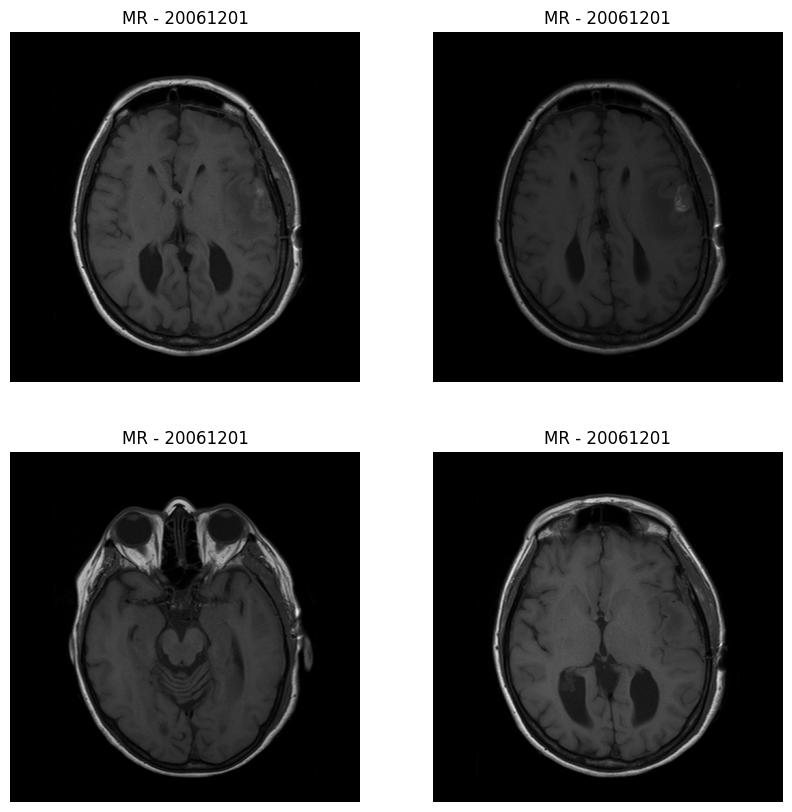

In [ ]:
info1 = pydicom.dcmread(T1_path_dicom +'/'+ selected_files[0])
info2 = pydicom.dcmread(T1_path_dicom +'/'+ selected_files[1])
info3 = pydicom.dcmread(T1_path_dicom +'/'+ selected_files[2])
info4 = pydicom.dcmread(T1_path_dicom +'/'+ selected_files[3])

img1 = info1.pixel_array
img2 = info2.pixel_array
img3 = info3.pixel_array
img4 = info4.pixel_array

fig, ax = plt.subplots(2,2,figsize=(10, 10))
ax[0,0].imshow(img1, cmap='gray') # Fila 1, Columna 1
ax[0,0].axis('off')
ax[0,0].set_title('{} - {}'.format(info1.Modality,info1.StudyDate))

ax[0,1].imshow(img2, cmap='gray') # Fila 1, Columna 1
ax[0,1].axis('off')
ax[0,1].set_title('{} - {}'.format(info2.Modality,info2.StudyDate))

ax[1,0].imshow(img3, cmap='gray') # Fila 1, Columna 1
ax[1,0].axis('off')
ax[1,0].set_title('{} - {}'.format(info3.Modality,info3.StudyDate))

ax[1,1].imshow(img4, cmap='gray') # Fila 1, Columna 1
ax[1,1].axis('off')
ax[1,1].set_title('{} - {}'.format(info4.Modality,info4.StudyDate))

plt.show()

In [ ]:
# <CODE> muestre el subplot para T2

### 5.3 Normalización de la imagen

La normalización de imágenes es un proceso que ajusta los valores de intensidad de los píxeles para que estén dentro de un rango específico. Esto es útil para mejorar el contraste y la visibilidad de características específicas en la imagen. La normalización puede ser especialmente importante en imágenes médicas, donde las intensidades pueden variar significativamente entre diferentes estudios o modalidades.

#### **Ejercicio 8**
Normalice la imagen DICOM cargada en el ejercicio 2. Puede usar la siguiente fórmula para normalizar los valores de intensidad:
```python
normalized_image = (image - np.min(image)) / (np.max(image) - np.min(image))
```

Compare el histograma de la imagen original con el de la imagen normalizada, puede convertir el arreglo 2D a un arreglo 1D usando los metodos de numpy `.ravel()` o `.flatten()`. Puede usar `plt.hist()` para mostrar los histogramas y `plt.show()` para visualizarlos.





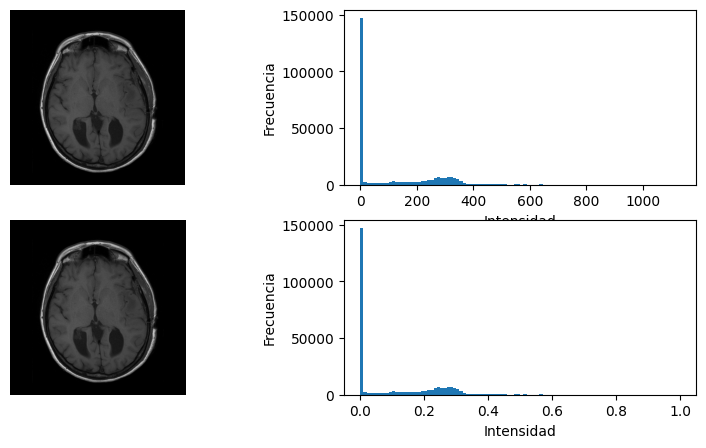

In [ ]:
# <CODE> muestre la imagen sin normalizar y normalizada, junto a sus histogramas
img1_sin_normalizar = T1.pixel_array
img1_normalizada = (img1_sin_normalizar - np.min(img1_sin_normalizar))/ (np.max(img1_sin_normalizar) - np.min(img1_sin_normalizar))

fig, ax = plt.subplots(2,2,figsize=(10, 5))
ax[0,0].imshow(img1_sin_normalizar, cmap='gray')
ax[0,0].axis('off')

ax[0,1].hist(img1_sin_normalizar.flatten(), 100)
ax[0,1].set_xlabel('Intensidad')
ax[0,1].set_ylabel('Frecuencia')

ax[1,0].imshow(img1_normalizada, cmap='gray')
ax[1,0].axis('off')

ax[1,1].hist(img1_normalizada.flatten(), 100)
ax[1,1].set_xlabel('Intensidad')
ax[1,1].set_ylabel('Frecuencia')
plt.show()

### 5.3 Ajuste de brillo y contraste
El ajuste de brillo y contraste es un proceso que modifica la intensidad de los píxeles en una imagen para mejorar su visibilidad. Esto es especialmente útil en imágenes médicas, donde ciertas estructuras pueden no ser claramente visibles debido a la variabilidad en la adquisición de imágenes.

El brillo se refiere a la cantidad de luz en la imagen, mientras que el contraste se refiere a la diferencia entre las áreas más claras y más oscuras de la imagen. Ajustar ambos parámetros puede ayudar a resaltar características específicas y facilitar el diagnóstico.

En particular , el ajuste de contraste puede ser útil para resaltar estructuras anatómicas o lesiones que de otro modo podrían pasar desapercibidas. Esto se logra al aumentar la diferencia entre los valores de intensidad de los píxeles, lo que hace que las áreas oscuras sean más oscuras y las áreas claras sean más claras. La formula básica para ajustar el contraste es:

$$I_{out} = I^\gamma$$

Donde $I_{out}$ es la imagen de salida, $I$ es la imagen de entrada e $\gamma$ es el factor gamma que controla el contraste. Un valor de $g$ mayor que 1 aumentará el contraste, mientras que un valor menor que 1 lo disminuirá.



#### **Ejercicio 9**
Ajusta el brillo y contraste de la imagen DICOM cargada en el ejercicio 2. Utiliza la fórmula mencionada anteriormente para ajustar el contraste. Experimenta con diferentes valores de gamma y observa cómo afecta la visualización de la imagen.


Text(0.5, 1.0, 'Gamma1.5')

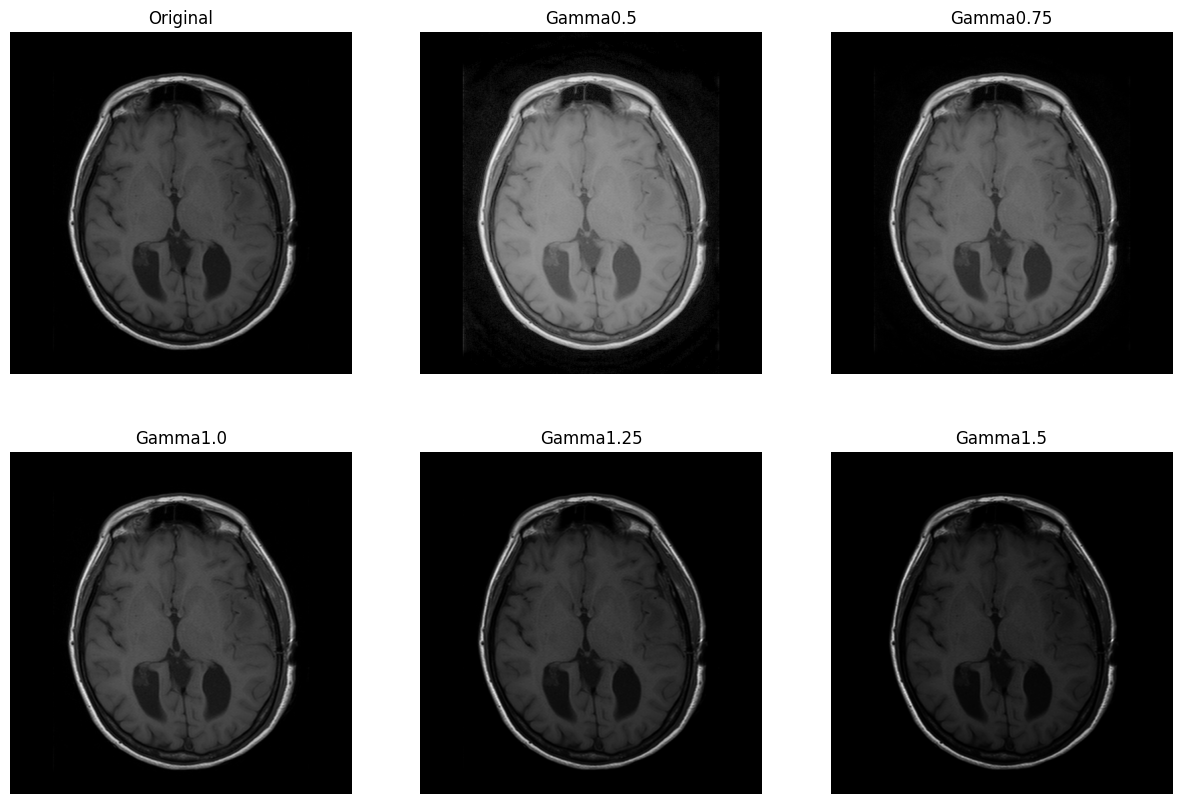

In [ ]:
# <CODE> muestre la imagen original y con ajuste de brillo, junto a sus histogramas
gamma_values = [0.5, 0.75, 1.0, 1.25, 1.5]
fig, ax = plt.subplots(2,3,figsize=(15,10))
ax[0,0].imshow(img1_normalizada, cmap='gray')
ax[0,0].axis('off')
ax[0,0].set_title('Original')

ax[0,1].imshow(img1_normalizada**gamma_values[0], cmap='gray')
ax[0,1].axis('off')
ax[0,1].set_title('Gamma'+str(gamma_values[0]))

ax[0,2].imshow(img1_normalizada**gamma_values[1], cmap='gray')
ax[0,2].axis('off')
ax[0,2].set_title('Gamma'+str(gamma_values[1]))

ax[1,0].imshow(img1_normalizada**gamma_values[2], cmap='gray')
ax[1,0].axis('off')
ax[1,0].set_title('Gamma'+str(gamma_values[2]))

ax[1,1].imshow(img1_normalizada**gamma_values[3], cmap='gray')
ax[1,1].axis('off')
ax[1,1].set_title('Gamma'+str(gamma_values[3]))

ax[1,2].imshow(img1_normalizada**gamma_values[4], cmap='gray')
ax[1,2].axis('off')
ax[1,2].set_title('Gamma'+str(gamma_values[4]))



## 6. Segmentación de imágenes

### 6.1 Umbralización

La segmentación de imágenes es un proceso que implica dividir una imagen en diferentes regiones o segmentos, cada uno de los cuales representa una característica o estructura específica. En el contexto de imágenes médicas, la segmentación es crucial para identificar y analizar estructuras anatómicas, lesiones o patologías.

La segmentación puede ser realizada de varias maneras, incluyendo técnicas basadas en umbralización, agrupamiento, y aprendizaje automático. En este ejercicio, nos centraremos en la segmentación por umbralización, que es una de las técnicas más simples para segmentar imágenes médicas.

El proceso de segmentación por umbralización implica establecer un valor de umbral y clasificar los píxeles de la imagen en dos categorías: aquellos que están por encima del umbral y aquellos que están por debajo.

Esto se puede realizar utilizando cualquier numpy array, y el resultado es una imagen binaria donde los píxeles que cumplen la condición se establecen en 1  y los demás en 0. Ejemplo:
```python
import numpy as np
import matplotlib.pyplot as plt

imagen = np.array([[0, 50, 100], [150, 200, 255]])
umbral = 100
mask = imagen > umbral
segmentada = imagen * mask
print(segmentada)
```

#### **Ejercicio 10**
Realice una segmentación binaria de la imagen DICOM cargada en el ejercicio 2 utilizando un valor de umbral fijo. La segmentación debe entregar como resultado la materia blanca del cerebro. Puede utilizar la imagen normalizada como entrada y aplicar correcciones de contraste si es necesario. Visualice la imagen original, su mascara y el resultado de la segmentación en un subplot de 1x3.



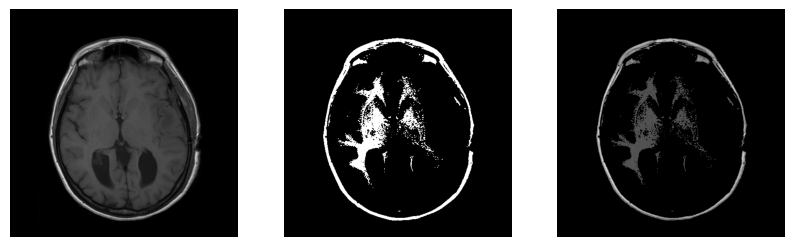

In [ ]:
# <CODE> muestre la imagen original, segmentacion y la aplicacion de la
# segmentacion sobre la imagen original
mask = img1_normalizada>0.3

fig, ax = plt.subplots(1,3,figsize=(10,5))
ax[0].imshow(img1_normalizada, cmap='gray')
ax[0].axis('off')
ax[1].imshow(mask, cmap='gray')
ax[1].axis('off')
ax[2].imshow(img1_normalizada*mask, cmap='gray')
ax[2].axis('off')

plt.show()

### 6.2  Mascara sombreada
La segmentación de imágenes médicas a menudo implica la creación de máscaras que resaltan áreas específicas de interés. Una técnica común es aplicar una máscara sombreada, que combina la imagen original con una máscara binaria para resaltar las áreas segmentadas.

#### **Ejercicio 11**
Aplique una máscara sombreada a la imagen DICOM cargada en el ejercicio 2 utilizando la máscara generada en el ejercicio 10. La máscara sombreada debe resaltar las áreas segmentadas en la imagen original. Visualice la imagen original, la máscara y la imagen con la máscara aplicada en un subplot de 1x3. Puede usar `plt.imshow()` para mostrar las imágenes y `plt.axis('off')` para ocultar los ejes.


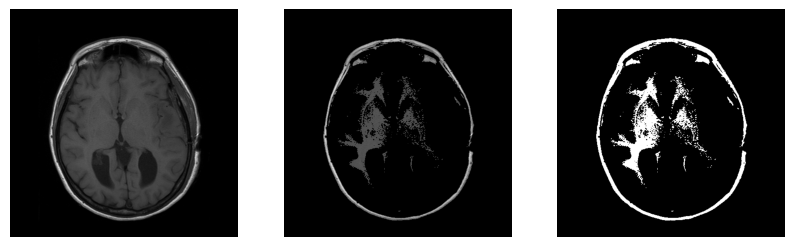

In [ ]:
# <CODE> muestre la imagen original, imagen segmentada y enmascarada
mask = img1_normalizada>0.3

fig, ax = plt.subplots(1,3,figsize=(10,5))
ax[0].imshow(img1_normalizada, cmap='gray')
ax[0].axis('off')
ax[1].imshow(img1_normalizada*mask, cmap='gray')
ax[1].axis('off')
ax[2].imshow(mask, cmap='gray')
ax[2].axis('off')
plt.show()

## 7. Guardado de imágenes

### 7.1 Guardado de imagenes en formato DICOM

Para guardar imágenes DICOM, puedes usar la función `save_as()` de la librería `pydicom`. Esto le permite guardar la imagen y los metadatos en un nuevo archivo DICOM. Por otra parte, es posible anonimizar la imagen eliminando o sobrescribiendo datos sensibles. Esto es especialmente importante en el contexto de imágenes médicas, donde la privacidad del paciente es fundamental.

Por ejemplo, puede eliminar el nombre del paciente y otros identificadores personales antes de guardar la imagen. Esto se puede hacer modificando directamente los atributos de la cabecera DICOM.
```python

dicom_file.PatientName = "Anonymous"
dicom_file.PatientID = "000000"

# o
dicom_file[0x0010, 0x0010].value = "Anonymous"
```

#### **Ejercicio 12**
Guarde la imagen DICOM cargada en el ejercicio 2 como un nuevo archivo DICOM. Asegurándose de anonimizar la imagen eliminando o sobrescribiendo los datos sensibles del paciente. Puede usar la función `save_as()` de `pydicom` para guardar la imagen y los metadatos en un nuevo archivo DICOM.



In [ ]:
# <CODE> Genere un codigo que guarde unas de las imagenes y anonimice los datos
# sensibles.

T1.PatientName = 'Anonymous'
T1.PatientID = '000000'
T1.save_as('anonimizada.dcm')

#### **Ejercicio 13**

Carga el archivo anonimizado y comprueba que los campos sensibles queden en blanco o contengan valores genéricos.


In [ ]:
# <CODE> Cargue el archivo que guardo y verifique que este anonimizada
# correctamente.
T1_an = pydicom.dcmread('anonimizada.dcm')
T1_an.PatientName

'Anonymous'

### 7.2 Guardado de imagenes en formato PNG
Para guardar imágenes en formato PNG, puedes usar la librería `PIL` (Python Imaging Library). Guardar la imagen en formato PNG le permite compartirla fácilmente y utilizarla en otros contextos. No obstante, es importante tener en cuenta que al guardar la imagen en un formato diferente, es posible que se pierdan gran parte de los metadatos y que la información de la imagen no sea completamente preservada.

Las imagenes se deben formatear de manera correcta para que sean guardadas en el formato deseado. En este caso, la imagen debe ser convertida a un formato compatible con PNG. Esto se puede hacer utilizando la función `convert()` de `PIL`. Por ejemplo, si la imagen es una matriz NumPy, puede convertirla a un objeto PIL de la siguiente manera:

```python
from PIL import Image
# Convertir la matriz NumPy a un objeto PIL
image_pil = Image.fromarray(normalized_image.astype(np.uint8))
```
Luego, puede guardar la imagen en formato PNG utilizando la función `save()` de `PIL`:
```python
image_pil.save('ruta/al/archivo.png')
```


#### **Ejercicio 14**
Guarde la imagen DICOM cargada en el ejercicio 2 como un nuevo archivo PNG. Genere 2 archivos PNG: uno con la imagen original y otro con la imagen normalizada. Comente las diferencias que se observan.


In [ ]:
# <CODE> Gaurde la imagen en archivo .png, imagen original e imagen normalizada
from PIL import Image

array = T1.pixel_array
image_pil = Image.fromarray(array.astype(np.uint8))
image_pil.save('original.png')

array = (T1.pixel_array - np.min(T1.pixel_array))/ (np.max(T1.pixel_array) - np.min(T1.pixel_array))
image_pil = Image.fromarray(array.astype(np.uint8))
image_pil.save('normalizada.png')

array = ((T1.pixel_array - np.min(T1.pixel_array))/ (np.max(T1.pixel_array) - np.min(T1.pixel_array)))*255
image_pil = Image.fromarray(array.astype(np.uint8))
image_pil.save('normalizada255.png')

___________________________________

# PROYECTO FINAL MODULO 1 DIADM

Fecha de entrega Lunes 3 de Noviembre de 2025.

GRUPO 4


*   Camila Contreras
*   Christian Pérez
*   Javier Uribe




____________________________________

### **Relevancia de la preparación de datos para Inteligencia Artificial en Imágenes Médicas**

En el desarrollo de soluciones de inteligencia artificial (IA) aplicadas al diagnóstico médico por imágenes, un paso fundamental —y muchas veces subestimado— es la preparación y exploración de los datos. La calidad y consistencia del conjunto de datos de entrenamiento puede afectar directamente el rendimiento, la generalización y la confiabilidad de los modelos de IA.

En este proyecto, se le asignará la primera etapa crítica del pipeline de un sistema de IA: la preparación y exploración de un conjunto de datos basado en imágenes médicas en formato DICOM. Este conjunto será eventualmente utilizado predecir la gravedad del deterioro de la función pulmonar de un paciente a partir de una tomografía computarizada (CT) y test de capacidad pulmonar.


### **Contexto clínico**

Imagina que, de un día para otro, tu respiración se vuelve constantemente dificultosa y superficial. Meses después, finalmente te diagnostican fibrosis pulmonar, un trastorno sin causa conocida y sin cura, provocado por cicatrices en los pulmones. Si eso te ocurriera, querrías saber cuál es tu pronóstico. Es en ese momento cuando una enfermedad preocupante se vuelve aterradora para el paciente: los resultados pueden variar desde una estabilidad a largo plazo hasta un deterioro rápido, pero los médicos no pueden determinar fácilmente en qué punto de ese espectro se encuentra cada persona. Tu ayuda, junto con la ciencia de datos, podría contribuir en esta predicción, lo que sería de gran ayuda tanto para los pacientes como para los profesionales de la salud.

Los métodos actuales dificultan el tratamiento de enfermedades pulmonares fibróticas, incluso teniendo acceso a tomografías computarizadas (CT) de tórax. Además, la amplia variabilidad en los pronósticos complica la organización de ensayos clínicos. Finalmente, los pacientes experimentan una ansiedad extrema —además de los síntomas propios de la fibrosis— debido al incierto curso de la enfermedad.

El Open Source Imaging Consortium (OSIC) es una iniciativa cooperativa sin fines de lucro entre el mundo académico, la industria y organizaciones filantrópicas. El grupo permite avances rápidos en la lucha contra la Fibrosis Pulmonar Idiopática (IPF), las enfermedades pulmonares intersticiales fibróticas (ILDs) y otras enfermedades respiratorias, incluidas las condiciones enfisematosas. Su misión es reunir a radiólogos, médicos y científicos computacionales de todo el mundo para mejorar los tratamientos basados en imágenes.

El desafío posterior a la preparación de datos, consiste en utilizar técnicas de aprendizaje automático para realizar predicciones utilizando como entrada la imagen, los metadatos y la FVC (capacidad vital forzada) basal. Se determinará la función pulmonar en base a los resultados de un espirómetro, el cual mide el volumen de aire inhalado y exhalado.

Si se tiene éxito, los pacientes y sus familias podrían comprender mejor su pronóstico al momento del diagnóstico de esta enfermedad pulmonar incurable. Una mejor detección de la gravedad también tendría un impacto positivo en el diseño de ensayos clínicos y aceleraría el desarrollo clínico de nuevos tratamientos.

### **Descripción del Conjunto de Datos**

El conjunton de dato fue extraido de la siguiente base de datos: https://www.kaggle.com/competitions/osic-pulmonary-fibrosis-progression/data. (**Adicionalmente pueden descargarlo del siguiente link de Google Drive:** https://drive.google.com/file/d/1r-I60Z55xXTHFCiCvIMsrajKdN53JnhE/view?usp=sharing )

En el conjunto de datos se proporciona una tomografía basal de tórax y la información clínica asociada para un grupo de pacientes. Cada paciente tiene una imagen adquirida en la semana 0 y múltiples visitas de seguimiento a lo largo de aproximadamente 1 a 2 años, en las cuales se mide su FVC.

En el conjunto de prueba se proporciona solo una tomografía basal y la medición inicial de FVC.

Hay aproximadamente 200 casos en total, combinando los conjuntos de prueba público y privado. Esta división es aproximadamente 15% público y 85% privado.

Dado que se trata de datos médicos reales, notarás que el tiempo relativo de las mediciones de FVC varía considerablemente. El momento de la medición inicial con respecto a la CT basal y la duración hasta los puntos de predicción puede ser diferente para cada paciente.

Los archivos y carpetas que usaremos en este proyecto son los siguientes:

**Archivos**

* `train.csv` - conjunto de entrenamiento, contiene el historial completo de información clínica

* `test.csv` - conjunto de prueba, contiene solo la medición basal

* `train/` - carpeta con las tomografías basales en formato DICOM de los pacientes del conjunto de entrenamiento

* `test/` - carpeta con las tomografías basales en formato DICOM de los pacientes del conjunto de prueba


**Columnas**

train.csv y test.csv

* `Patient`: identificador único de cada paciente (también es el nombre de la carpeta DICOM del paciente)

* `Weeks`: número de semanas relativas respecto a la CT basal (puede ser negativo)

* `FVC`: capacidad pulmonar registrada, en mililitros

* `Percent`: campo calculado que aproxima el FVC del paciente como un porcentaje del FVC típico para una persona con características similares

* `Age`: edad

* `Sex`: sexo

* `SmokingStatus`: historial de tabaquismo


In [ ]:
# Monte su Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Descomprimir la carpeta que esta en el google drive, y la esta guardando en el mismo directorio de google drive (Ya se hizo)
#!unzip '/content/drive/MyDrive/Clases IA/Colab Notebooks/CÓDIGOS - PYTHON-20250912/Taller4/osic-pulmonary-fibrosis-progression.zip' -d '/content/drive/MyDrive/Clases IA/Colab Notebooks/CÓDIGOS - PYTHON-20250912/Taller4/datos_proyecto_final'

In [6]:
# Instalamos los modulos que haya que instalar para poder ejecutar nuestro codigo
!pip install pydicom
!pip install opencv-python


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 71.4 MB/s eta 0:00:00 MB/s eta 0:00:01:01


In [7]:
# Importamos los modulos
import os
import cv2
import numpy as np
import pandas as pd
import pydicom
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### **Tareas que deben abordar en este proyecto**

1. **Análisis exploratorio de datos (40% de la nota final).**

* Lea los datos de `train.csv` en un dataframe llamado `base_de_datos`.
* Reponda las siguientes preguntas a partir del dataframe anterior y muestre un gráfico asociado a cada una de ellas.



In [10]:
!ls

Datos
osic-pulmonary-fibrosis-progression.zip
TALLER_4_DIADM_Analisis_de_Imagenes.ipynb
TALLER_4_DIADM_Analisis_de_Imagenes_versionCami.ipynb


In [12]:
# <CODE> lea el achivo train.csv
base_de_datos = pd.read_csv('Datos/train.csv')
base_de_datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1549 entries, 0 to 1548
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Patient        1549 non-null   object 
 1   Weeks          1549 non-null   int64  
 2   FVC            1549 non-null   int64  
 3   Percent        1549 non-null   float64
 4   Age            1549 non-null   int64  
 5   Sex            1549 non-null   object 
 6   SmokingStatus  1549 non-null   object 
dtypes: float64(1), int64(3), object(3)
memory usage: 84.8+ KB


In [13]:
#Se cambian los nombres de las columnas para que queden en español y así sea más
#directo graficar

base_de_datos = base_de_datos.rename(columns={
    'Patient': 'Paciente', 'Weeks': 'Semanas', 'FVC': 'FVC', 'Percent': 'Porcentaje',
    'Age': 'Edad', 'Sex': 'Sexo', 'SmokingStatus': 'Historial_Tabaquismo'
}).replace({
    'Male': 'Masculino', 'Female': 'Femenino',
    'Never smoked': 'Nunca fumó', 'Ex-smoker': 'Ex fumador', 'Currently smokes': 'Fumador actual'
})
base_de_datos.head()
base_de_datos.tail()

,Paciente,Semanas,FVC,Porcentaje,Edad,Sexo,Historial_Tabaquismo
1544,ID00426637202313170790466,13,2712,66.594637,73,Masculino,Nunca fumó
1545,ID00426637202313170790466,19,2978,73.126412,73,Masculino,Nunca fumó
1546,ID00426637202313170790466,31,2908,71.407524,73,Masculino,Nunca fumó
1547,ID00426637202313170790466,43,2975,73.052745,73,Masculino,Nunca fumó
1548,ID00426637202313170790466,59,2774,68.117081,73,Masculino,Nunca fumó


In [14]:
#Agrupo por id paciente. Hay entradas que se repiten por ID, entonces se agrupan
#se crea un nuevo df

agrupado_por_pcte = base_de_datos.groupby('Paciente')

# Crear resumen general de cada paciente
#se considera el primer valor para edad, sexo, histialTBQ
#al contar las semanas de cada pcte tenemos cuantos registros tuvo
resumen_pacientes = agrupado_por_pcte.agg({
    'Edad': 'first',
    'Sexo': 'first',
    'Historial_Tabaquismo': 'first',
    'Semanas': ['min', 'max', 'count'],
    'FVC': ['mean', 'min', 'max'],
    'Porcentaje': 'mean'
}).reset_index()
resumen_pacientes.columns = [
    'Paciente', 'Edad', 'Sexo', 'Historial_Tabaquismo',
    'Semana_Min', 'Semana_Max', 'Cantidad_Registros',
    'FVC_Promedio', 'FVC_Min', 'FVC_Max', 'Porcentaje_Promedio'
]

# Mostrar primeras filas
resumen_pacientes.head()
#print(resumen_pacientes.shape)

,Paciente,Edad,Sexo,Historial_Tabaquismo,Semana_Min,Semana_Max,Cantidad_Registros,FVC_Promedio,FVC_Min,FVC_Max,Porcentaje_Promedio
0,ID00007637202177411956430,79,Masculino,Ex fumador,-4,57,9,2113.888889,2000,2315,53.192977
1,ID00009637202177434476278,69,Masculino,Ex fumador,8,60,9,3596.666667,3214,3895,83.807127
2,ID00010637202177584971671,60,Masculino,Ex fumador,0,54,9,3037.111111,2474,3523,81.660333
3,ID00011637202177653955184,72,Masculino,Ex fumador,6,58,9,3387.000000,3193,3541,87.564633
4,ID00012637202177665765362,65,Masculino,Nunca fumó,33,87,9,3348.777778,2971,3759,91.827843


#### PREGUNTA 1.1

¿ Cuantos pacientes son no-fumadores, ex-fumadores y fumadores?.

In [15]:
# <CODE> genere un codigo que permita analizar la pregunta.
#se usa el resumen_pacientes creado para los calculos y gráficos
Historial_TBQ = resumen_pacientes['Historial_Tabaquismo'].value_counts()
Historial_TBQ

Historial_Tabaquismo
Ex fumador        118
Nunca fumó         49
Fumador actual      9
Name: count, dtype: int64

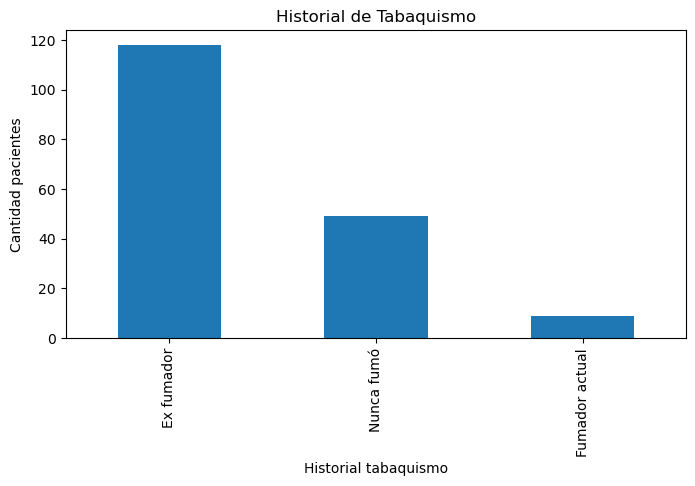

In [16]:
# <CODE> muestre un grafico.
Historial_TBQ.plot(kind='bar', figsize=(8,4))
plt.title('Historial de Tabaquismo')
plt.xlabel('Historial tabaquismo')
plt.ylabel('Cantidad pacientes')
plt.show()

<font color='red'>RESPONDA ACA LA PREGUNTA 1.1</font>


De los 176 pacientes


*  Ex fumador son 118
*  Nunca fumó 49
*  Fumador actual 9


#### PREGUNTA 1.2

De los pacientes descritos en el punto anterior ¿ cuantas mujeres y cuantos hombres hay en cada uno de los grupos?.

In [17]:
# <CODE> genere un codigo que permita analizar la pregunta.
crosstab_sexo_tbq = pd.crosstab(resumen_pacientes['Historial_Tabaquismo'],
                                resumen_pacientes['Sexo'])
crosstab_sexo_tbq

crosstab_sexo_tbq2 = pd.crosstab(
    resumen_pacientes['Historial_Tabaquismo'],
    resumen_pacientes['Sexo'],
    margins=True, margins_name='Total')
crosstab_sexo_tbq2

Sexo,Femenino,Masculino,Total
Historial_Tabaquismo,,,
Ex fumador,12,106,118
Fumador actual,2,7,9
Nunca fumó,23,26,49
Total,37,139,176


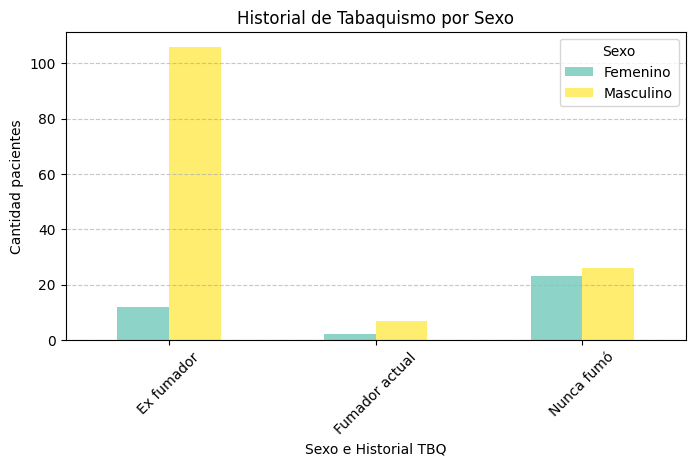

In [ ]:
# <CODE> muestre un grafico.
crosstab_sexo_tbq.plot(kind='bar', figsize=(8,4),colormap='Set3')
plt.title('Historial de Tabaquismo por Sexo')
plt.xlabel('Sexo e Historial TBQ')
plt.ylabel('Cantidad pacientes')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

<font color='red'>RESPONDA ACA LA PREGUNTA 1.2</font>

La distribución de pacientes por sexo y categoría de historial de tabaquismo es la siguiente:

Ex fumadores: 12 mujeres y 106 hombres, sumando un total de 118 pacientes.

Fumadores actuales: 2 mujeres y 7 hombres, con un total de 9 pacientes.

Nunca fumó: 23 mujeres y 26 hombres, lo que da un total de 49 pacientes.

En total, participaron 37 mujeres y 139 hombres, alcanzando un total general de 176 pacientes.

#### PREGUNTA 1.3

Separe las edades de los pacientes en 3 grupos del mismo rango, ¿cuantos pacientes hay en cada uno de los grupos?.
    
    

In [18]:
#un codigo que permita analizar la pregunta.
#se hacen 3 bins para las edades
grupos_edades = pd.cut(resumen_pacientes['Edad'], bins=3)
conteo = grupos_edades.value_counts().sort_index()
print(conteo)

Edad
(48.961, 62.0]     40
(62.0, 75.0]      117
(75.0, 88.0]       19
Name: count, dtype: int64


In [19]:
# Se hacen los tres bins, pero al final se redondea el extremo inferior
#solo para que salga numero entero al graficar
min_edad = resumen_pacientes['Edad'].min()
max_edad = resumen_pacientes['Edad'].max()
grupos_edades = pd.cut(resumen_pacientes['Edad'], bins=3)
conteo = grupos_edades.value_counts().sort_index()
#print(conteo)
indice = ['48.0 - 62.0', '62.0 - 75.0', '75.0 - 88.0']

conteo.index = indice
conteo
print(conteo)

48.0 - 62.0     40
62.0 - 75.0    117
75.0 - 88.0     19
Name: count, dtype: int64


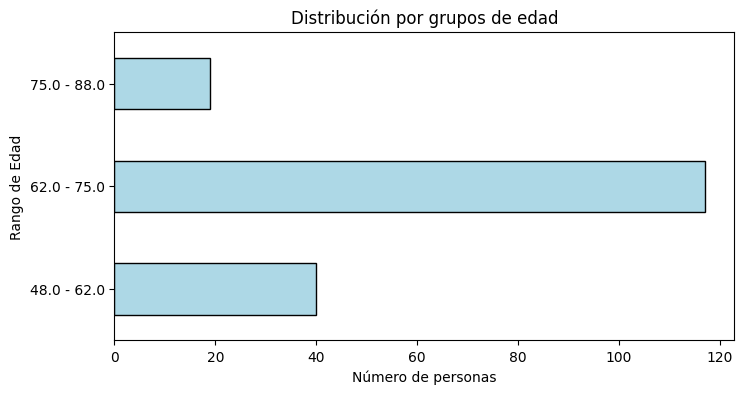

In [ ]:
conteo.plot(kind='barh', figsize=(8,4), color="lightblue", edgecolor="black")
plt.title('Distribución por grupos de edad')
plt.xlabel('Número de personas')
plt.ylabel('Rango de Edad')
plt.show()


<font color='red'>RESPONDA ACA LA PREGUNTA 1.3</font>



*   Primer rango 48 a 62 años  = 40
*   Segundo rango 62 a 75 años = 117
*   Tercer rango 75 a 88 años  = 19

#### PREGUNTA 1.4

Agrupe la primera y ultima medición de FVC para cada uno de los pacientes, seperados por estatus de fumador, calcule su promedio y desviacion estandar. ¿ cual es el grupo que presenta mayor deterioro en la FCV, entre la primera y ultima medición ?

    

In [20]:
# <CODE> genere un codigo que permita analizar la pregunta.

fvc_primera = base_de_datos.groupby('Paciente').first()['FVC']
fvc_ultima = base_de_datos.groupby('Paciente').last()['FVC']

# Calcular deterioro (última - primera)
deterioro = fvc_ultima - fvc_primera

# Crear un DataFrame con el historial de tabaquismo de cada paciente
tabaquismo = base_de_datos.groupby('Paciente')['Historial_Tabaquismo'].first()

# Combinar todo
df_deterioro = pd.DataFrame({
    'Historial_Tabaquismo': tabaquismo,
    'Deterioro_FVC': deterioro
}).reset_index()

# Agrupar por tabaquismo y calcular promedio y desviación estándar
resumen_deterioro = df_deterioro.groupby('Historial_Tabaquismo')['Deterioro_FVC'].agg(['mean', 'std', 'count'])
print(resumen_deterioro)
deterioro_grupos = df_deterioro.groupby('Historial_Tabaquismo')['Deterioro_FVC'].mean()
deterioro_grupos

                            mean         std  count
Historial_Tabaquismo                               
Ex fumador           -264.593220  309.543619    118
Fumador actual         54.222222  185.398070      9
Nunca fumó           -240.877551  269.640782     49


Historial_Tabaquismo
Ex fumador       -264.593220
Fumador actual     54.222222
Nunca fumó       -240.877551
Name: Deterioro_FVC, dtype: float64

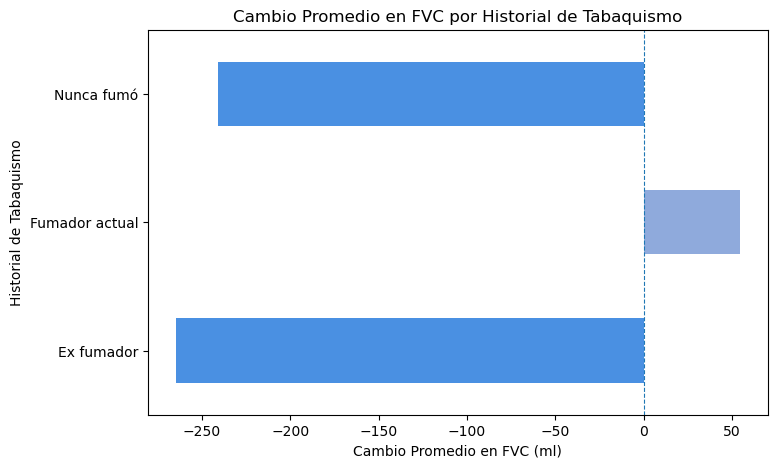

In [21]:
# <CODE> muestre un grafico.
ax = deterioro_grupos.plot(
    kind="barh",
    figsize=(8,5),
    color=["#4A90E2" if v < 0 else '#8FAADC' for v in resumen_deterioro['mean'].values]
)

# Título y etiquetas
plt.title('Cambio Promedio en FVC por Historial de Tabaquismo')
plt.xlabel('Cambio Promedio en FVC (ml)')
plt.ylabel('Historial de Tabaquismo')

# Línea horizontal en cero
plt.axvline(0, linestyle='--', linewidth=0.8)

plt.show()

<font color='red'>RESPONDA ACA LA PREGUNTA 1.4</font>

En promedio, el grupo de ex fumadores presenta el mayor deterioro en la capacidad vital forzada (FVC), con una disminución promedio de –264,6 ml.
Le sigue el grupo de quienes nunca fumaron, con una caída media de –240,9 ml.
Por el contrario, los fumadores actuales muestran un aumento promedio de 54,2 ml, aunque este resultado puede deberse a la pequeña cantidad de casos (9 pacientes).

En conjunto, estos datos sugieren que los ex fumadores experimentan el mayor deterioro en la función pulmonar (FVC) entre los grupos analizados.

#### PREGUNTA 1.5

¿ Cuantas semanas en promedio existen entre la primera y ultima medicion de FCV entre todos los pacientes ?.

In [22]:
# <CODE> genere un codigo que permita analizar la pregunta.
FCV_primera = base_de_datos.groupby('Paciente').first()['Semanas']
FVC_ultima = base_de_datos.groupby('Paciente').last()['Semanas']
promedio_semanas = FVC_ultima - FCV_primera
promedio_semanas

Paciente
ID00007637202177411956430    61
ID00009637202177434476278    52
ID00010637202177584971671    54
ID00011637202177653955184    52
ID00012637202177665765362    54
                             ..
ID00419637202311204720264    53
ID00421637202311550012437    55
ID00422637202311677017371    41
ID00423637202312137826377    53
ID00426637202313170790466    59
Name: Semanas, Length: 176, dtype: int64

In [23]:
promedio_semanas.describe()

count    176.000000
mean      52.448864
std        7.841844
min       25.000000
25%       53.000000
50%       54.000000
75%       57.000000
max       63.000000
Name: Semanas, dtype: float64

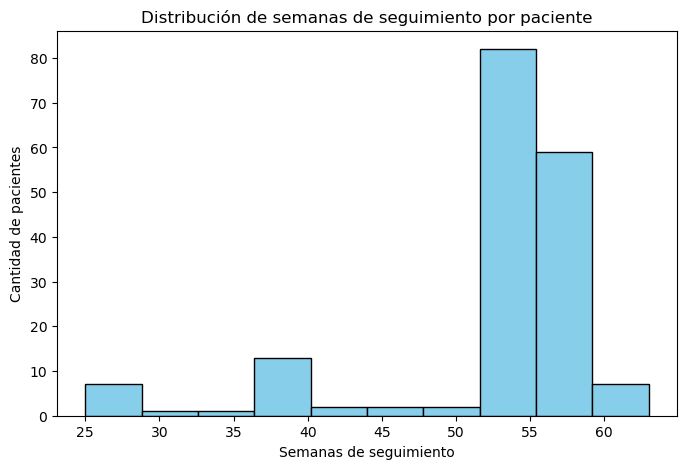

In [24]:
plt.figure(figsize=(8, 5))
plt.hist(promedio_semanas, bins=10, color='skyblue', edgecolor='black')
plt.title('Distribución de semanas de seguimiento por paciente')
plt.xlabel('Semanas de seguimiento')
plt.ylabel('Cantidad de pacientes')
plt.show()


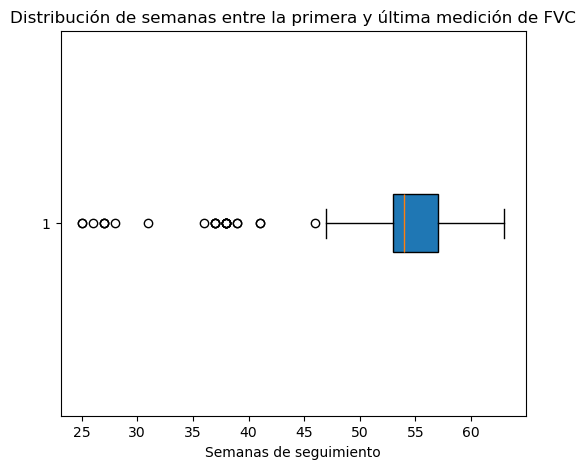

In [25]:
#otro grafico que también evidencia que la mayoria está entre
plt.figure(figsize=(6, 5))
plt.boxplot(promedio_semanas, vert=False, patch_artist=True)
plt.title('Distribución de semanas entre la primera y última medición de FVC')
plt.xlabel('Semanas de seguimiento')
plt.show()


<font color='red'>RESPONDA ACA LA PREGUNTA 1.5</font>

De acuerdo con los resultados, el seguimiento de los pacientes tuvo una duración promedio de 52,4 semanas, con una desviación estándar de 7,8 semanas, lo que indica cierta variabilidad en la cantidad de tiempo entre la primera y la última medición de FVC.

El rango de seguimiento va desde un mínimo de 25 semanas hasta un máximo de 63 semanas.
Además, la mitad de los pacientes (mediana = 54 semanas) tuvo un seguimiento comprendido entre aproximadamente 53 y 57 semanas.

En resumen, la mayoría de los pacientes fue evaluada durante alrededor de un año, con pocas diferencias entre casos.

2. **Análisis de imágenes DICOM (50% de la nota final).**

* Genere un dataframe llamado `base_de_imagenes`, a partir de la información contenida en las carpetas `train/`, con las siguientes columnas:

  * `Patient`: identificador único de cada paciente (también es el nombre de la carpeta DICOM del paciente).
  * `Carpeta`: identificador que indica el nombre de la carpeta train o test.
  * `Rows`: número de filas de la imágen.
  * `Columns`: número de columnas de la imágen.
  * `Num_files`: cantidad de archivos contenidos en cada una de las carpetas.
  * `PixelSpacing_0`: tamaño de pixel en direccion de las filas.
  * `PixelSpacing_1`: tamaño de pixel en direccion de las columnas.
  * `SpacingBetweenSlices`: espaciado entre slices.
  * `SliceThickness`: espezor de slice.
  * `Manufacturer`: marca del equipo donde se adquirieron las imagenes.
  * `KVP`: Pico de kilo voltaje de salida del generador de rayos X utilizado.
  * `XRayTubeCurrent`: Corriente del tubo de rayos X en mA.
  * `GeneratorPower`:	Potencia en kW del generador de rayos X.

* Reponda las siguientes preguntas a partir del dataframe generado y muestre un gráfico asociado a cada una de ellas.



In [28]:
# <CODE> genere la base_de_imagenes con la informacion contenida en train/
import os
import pydicom
import pandas as pd

# Ruta base del dataset
ruta_train = 'Datos/train'

# Definir las columnas de la base de datos
columnas = [
    'Patient', 'Carpeta', 'Rows', 'Columns', 'Num_files',
    'PixelSpacing_0', 'PixelSpacing_1', 'SpacingBetweenSlices',
    'SliceThickness', 'Manufacturer', 'KVP', 'XRayTubeCurrent', 'GeneratorPower'
]

# Crear el DataFrame vacío
base_de_imagenes = pd.DataFrame(columns=columnas)

# Recorrer cada carpeta de paciente
for paciente in os.listdir(ruta_train):
    carpeta_paciente = os.path.join(ruta_train, paciente)
    if not os.path.isdir(carpeta_paciente):
        continue

    archivos_dicom = [f for f in os.listdir(carpeta_paciente) if f.endswith('.dcm')]
    num_files = len(archivos_dicom)

    if num_files == 0:
        continue

    # Leer un archivo DICOM como muestra
    muestra = pydicom.dcmread(os.path.join(carpeta_paciente, archivos_dicom[0]))

    # Extraer la información (con verificación de existencia)
    data = {
        'Patient': paciente,
        'Carpeta': carpeta_paciente,
        'Rows': getattr(muestra, 'Rows', None),
        'Columns': getattr(muestra, 'Columns', None),
        'Num_files': num_files,
        'PixelSpacing_0': getattr(muestra, 'PixelSpacing', [None, None])[0],
        'PixelSpacing_1': getattr(muestra, 'PixelSpacing', [None, None])[1],
        'SpacingBetweenSlices': getattr(muestra, 'SpacingBetweenSlices', None),
        'SliceThickness': getattr(muestra, 'SliceThickness', None),
        'Manufacturer': getattr(muestra, 'Manufacturer', None),
        'KVP': getattr(muestra, 'KVP', None),
        'XRayTubeCurrent': getattr(muestra, 'XRayTubeCurrent', None),
        'GeneratorPower': getattr(muestra, 'GeneratorPower', None)
    }

    base_de_imagenes = pd.concat([base_de_imagenes, pd.DataFrame([data])], ignore_index=True)

# Mostrar la base resultante
base_de_imagenes.head()

,Patient,Carpeta,Rows,Columns,Num_files,PixelSpacing_0,PixelSpacing_1,SpacingBetweenSlices,SliceThickness,Manufacturer,KVP,XRayTubeCurrent,GeneratorPower
0,ID00009637202177434476278,Datos/train/ID00009637202177434476278,768,768,394,0.486979,0.486979,NaN,1.25,SIEMENS,130.0,176,25
1,ID00355637202295106567614,Datos/train/ID00355637202295106567614,512,512,37,0.679688,0.679688,NaN,1.00,SIEMENS,120.0,87,22
2,ID00014637202177757139317,Datos/train/ID00014637202177757139317,843,888,31,0.798828,0.798828,NaN,1.25,GE MEDICAL SYSTEMS,120.0,432,78000
3,ID00251637202267455595113,Datos/train/ID00251637202267455595113,512,512,28,0.585938,0.585938,NaN,1.00,SIEMENS,130.0,72,11
4,ID00232637202260377586117,Datos/train/ID00232637202260377586117,512,512,67,0.683000,0.683000,NaN,5.00,TOSHIBA,120.0,300,36


In [29]:
base_de_imagenes.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176 entries, 0 to 175
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Patient               176 non-null    object 
 1   Carpeta               176 non-null    object 
 2   Rows                  176 non-null    object 
 3   Columns               176 non-null    object 
 4   Num_files             176 non-null    object 
 5   PixelSpacing_0        176 non-null    float64
 6   PixelSpacing_1        176 non-null    float64
 7   SpacingBetweenSlices  42 non-null     float64
 8   SliceThickness        176 non-null    float64
 9   Manufacturer          176 non-null    object 
 10  KVP                   176 non-null    float64
 11  XRayTubeCurrent       175 non-null    object 
 12  GeneratorPower        135 non-null    object 
dtypes: float64(5), object(8)
memory usage: 18.0+ KB


#### PREGUNTA 2.1

¿ Cuantos equipos de CT distintos se utilizaron en la base de datos, y cuantos pacientes hay por cada uno de ellos ?

In [30]:
# <CODE> genere un codigo que permita analizar la pregunta.
equipos = base_de_imagenes['Manufacturer'].value_counts()
print("Se usaron" , equipos.count(), "equipos")
equipos

Se usaron 7 equipos


Manufacturer
SIEMENS                        74
GE MEDICAL SYSTEMS             45
Philips                        28
TOSHIBA                        26
Hitachi Medical Corporation     1
PACSMATT                        1
PACSGEAR                        1
Name: count, dtype: int64

In [31]:
equipos_df = equipos.reset_index()
equipos_df.columns = ['Equipo', 'Cantidad']
display(equipos_df)


,Equipo,Cantidad
0,SIEMENS,74
1,GE MEDICAL SYSTEMS,45
2,Philips,28
3,TOSHIBA,26
4,Hitachi Medical Corporation,1
5,PACSMATT,1
6,PACSGEAR,1


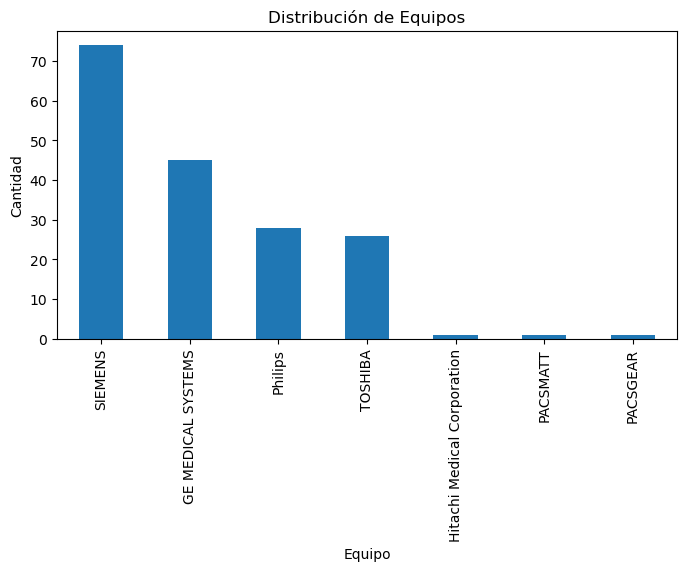

In [32]:
# <CODE> muestre un grafico.
equipos.plot(kind='bar', figsize=(8,4))
plt.title('Distribución de Equipos')
plt.xlabel('Equipo')
plt.ylabel('Cantidad')
plt.show()


<font color='red'>RESPONDA ACA LA PREGUNTA 2.1</font>

Se Usaron 7 equipos distintos.

Según los datos, la mayoría de los estudios fueron realizados con equipos SIEMENS, que representan 74 casos, seguidos por GE Medical Systems con 45 casos y Philips con 28.

En menor proporción, se utilizaron equipos Toshiba (26 casos), mientras que PACSMATT, Hitachi Medical Corporation y PACSGEAR participaron solo con 1 caso cada uno.

En conjunto, se observa que SIEMENS es la marca más utilizada en los registros analizados.


#### PREGUNTA 2.2
¿ Existe una relacion entre la cantidad de imágenes en cada carpeta y el equipo con el que se adquirieron ?

In [33]:
#  <CODE> genere un codigo que permita analizar la pregunta.
#Cantidad total y promedio de imágenes por equipo
resumen = base_de_imagenes.groupby('Manufacturer')['Num_files'].agg(['count', 'sum', 'mean']).sort_values('mean', ascending=False)
resumen

,count,sum,mean
Manufacturer,,,
Philips,28,7158,255.642857
Hitachi Medical Corporation,1,253,253.0
TOSHIBA,26,5703,219.346154
GE MEDICAL SYSTEMS,45,8497,188.822222
SIEMENS,74,11363,153.554054
PACSGEAR,1,28,28.0
PACSMATT,1,24,24.0


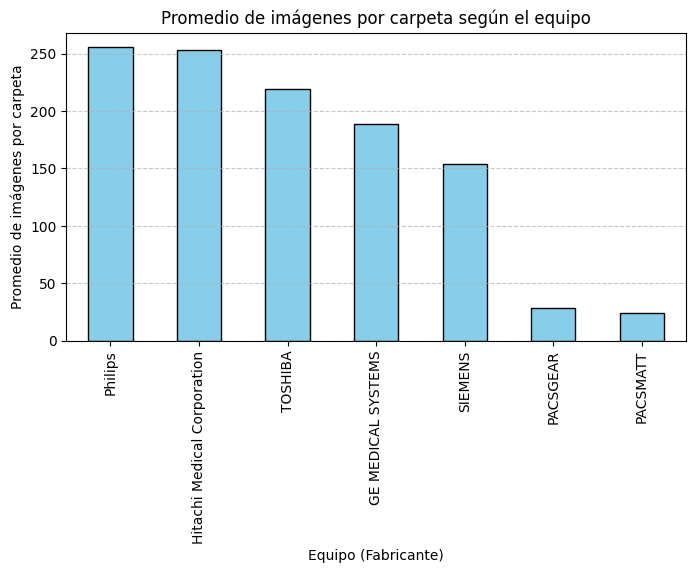

In [ ]:
# <CODE> muestre un grafico.
# Gráfico: promedio de imágenes por equipo
resumen['mean'].plot(kind='bar', figsize=(8,4), color='skyblue', edgecolor='black')
plt.title('Promedio de imágenes por carpeta según el equipo')
plt.xlabel('Equipo (Fabricante)')
plt.ylabel('Promedio de imágenes por carpeta')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=90)
plt.show()

<font color='red'>RESPONDA ACA LA PREGUNTA 2.2</font>

Interpretación

Sí existe una relación observable entre el equipo (Manufacturer) y la cantidad de imágenes por carpeta (paciente).

Los equipos Philips y Hitachi tienden a generar mayor número de imágenes por paciente, mientras que Siemens y GE producen menos imágenes en promedio.

PACSGEAR y PACSMATT están muy por debajo del promedio.

Conclusión:

Se observa una diferencia notable en la cantidad promedio de imágenes por carpeta entre fabricantes.
Los equipos de Philips y TOSHIBA generan más imágenes por paciente, mientras que Siemens y GE Medical Systems producen menos.
Esto sugiere una relación entre el fabricante del equipo y el tamaño del conjunto de imágenes adquiridas.

#### PREGUNTA 2.3

¿ Como es la relación entre KVP y XRayTubeCurrent ?

In [34]:
# <CODE> genere un codigo que permita analizar la pregunta.
KVP_XRayTubeCurrent = base_de_imagenes[['KVP', 'XRayTubeCurrent']]
KVP_XRayTubeCurrent
print(KVP_XRayTubeCurrent)

correlacion = KVP_XRayTubeCurrent.corr(method='pearson')
correlacion


       KVP XRayTubeCurrent
0    130.0             176
1    120.0              87
2    120.0             432
3    130.0              72
4    120.0             300
..     ...             ...
171  140.0             135
172  120.0             400
173  120.0             737
174  100.0             335
175  135.0             342

[176 rows x 2 columns]


,KVP,XRayTubeCurrent
KVP,1.000000,-0.148789
XRayTubeCurrent,-0.148789,1.000000


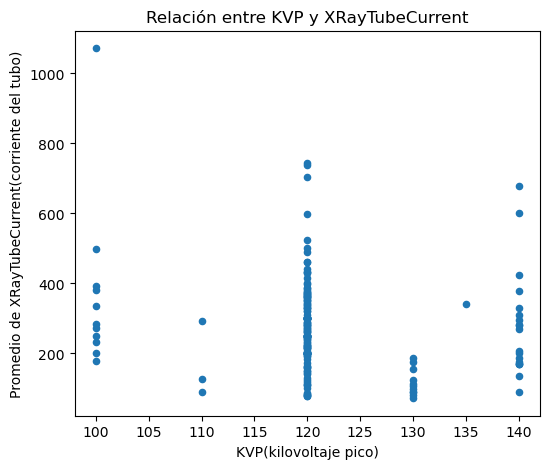

In [35]:
# <CODE> muestre un grafico.
KVP_XRayTubeCurrent.plot(kind='scatter',x='KVP', y='XRayTubeCurrent', figsize=(6,5))
plt.title('Relación entre KVP y XRayTubeCurrent')
plt.xlabel('KVP(kilovoltaje pico)')
plt.ylabel('Promedio de XRayTubeCurrent(corriente del tubo)')
plt.show()

<font color='red'>RESPONDA ACA LA PREGUNTA 2.3</font>
Teoricamente a mayor Corriente de tubo hay posibilidad de mayor KVP, sin embargo estos dependen especificamente de los protocolos y por eso no hay tanta dispersion en esos valores. Sin embargo la corriente de tubo dependera del equipo, que puede ser del mismo fabricante pero ser modelos distintos.
Al aplicar metodo de Pearson a la correlación no se observa una relación lineal significativa entre KVP y XRayTubeCurrent (r = –0.166).
La correlación es débil y negativa, por lo que no se puede establecer una correlación entre ambos para estos datos.

#### PREGUNTA 2.4
¿ Todos volumenes tienen el mismo tamaño ?.

In [36]:
base_de_imagenes[['Rows', 'Columns']].drop_duplicates()

,Rows,Columns
0,768,768
1,512,512
2,843,888
54,1302,1302
72,752,888
73,632,632
95,788,888
97,734,888
130,1100,888
149,733,888


In [37]:
base_de_imagenes['Num_files'].value_counts()

Num_files
30     9
64     5
31     5
24     5
33     4
      ..
364    1
407    1
52     1
355    1
87     1
Name: count, Length: 121, dtype: int64

In [38]:
# <CODE> genere un codigo que permita analizar la pregunta.
# Convertir columnas numéricas que están como object
base_de_imagenes['Num_files'] = base_de_imagenes['Num_files'].astype(int)
base_de_imagenes['Rows'] = base_de_imagenes['Rows'].astype(int)
base_de_imagenes['Columns'] = base_de_imagenes['Columns'].astype(int)
base_de_imagenes['XRayTubeCurrent'] = pd.to_numeric(base_de_imagenes['XRayTubeCurrent'],
                                                    errors='coerce')
base_de_imagenes['GeneratorPower'] = pd.to_numeric(base_de_imagenes['GeneratorPower'],
                                                   errors='coerce')

# 1. Número de slices por paciente
slices_por_paciente = base_de_imagenes.groupby('Patient')['Num_files'].sum()
print("Número de slices por paciente:")
print(slices_por_paciente)

# Verificar si todos los volúmenes tienen el mismo número de slices
if slices_por_paciente.nunique() == 1:
    print(f"\nTodos los volúmenes tienen el mismo tamaño: {slices_por_paciente.iloc[0]} slices.")
else:
    print(f"\nLos volúmenes NO tienen el mismo tamaño. Diferentes cantidades de slices por paciente:")
    print(slices_por_paciente.value_counts())

    # 2. Verificar dimensiones de cada slice
dims_por_paciente = base_de_imagenes.groupby('Patient').agg({'Rows':'first', 'Columns':'first'})
print("\nDimensiones de cada paciente (Rows x Columns):")
print(dims_por_paciente)

# Verificar si todas las dimensiones son iguales
if dims_por_paciente.nunique().eq(1).all():
    print("\nTodas las imágenes tienen la misma resolución (Rows x Columns).")
else:
    print("\nLas imágenes tienen resoluciones diferentes entre pacientes.")

resumen = pd.concat([slices_por_paciente, dims_por_paciente], axis=1)
resumen

Número de slices por paciente:
Patient
ID00007637202177411956430     30
ID00009637202177434476278    394
ID00010637202177584971671    106
ID00011637202177653955184     31
ID00012637202177665765362     49
                            ... 
ID00419637202311204720264     28
ID00421637202311550012437     62
ID00422637202311677017371    473
ID00423637202312137826377    290
ID00426637202313170790466    408
Name: Num_files, Length: 176, dtype: int64

Los volúmenes NO tienen el mismo tamaño. Diferentes cantidades de slices por paciente:
Num_files
30     9
31     5
24     5
64     5
56     4
      ..
265    1
278    1
250    1
473    1
290    1
Name: count, Length: 121, dtype: int64

Dimensiones de cada paciente (Rows x Columns):
                           Rows  Columns
Patient                                 
ID00007637202177411956430   512      512
ID00009637202177434476278   768      768
ID00010637202177584971671   512      512
ID00011637202177653955184   512      512
ID00012637202177665765362

,Num_files,Rows,Columns
Patient,,,
ID00007637202177411956430,30,512,512
ID00009637202177434476278,394,768,768
ID00010637202177584971671,106,512,512
ID00011637202177653955184,31,512,512
ID00012637202177665765362,49,512,512
...,...,...,...
ID00419637202311204720264,28,1100,888
ID00421637202311550012437,62,768,768
ID00422637202311677017371,473,512,512


In [39]:
# Si SpacingBetweenSlices tiene NaN, usamos SliceThickness como aproximación y en valor absoluto para no tener valores negativos
base_de_imagenes['SliceSpacing'] = base_de_imagenes['SpacingBetweenSlices'].fillna(base_de_imagenes['SliceThickness']).abs()

# Calcular volumen por slice (en mm^3)
base_de_imagenes['Vol_slice'] = base_de_imagenes['Rows'] * base_de_imagenes['Columns'] * base_de_imagenes['PixelSpacing_0'] * base_de_imagenes['PixelSpacing_1'] * base_de_imagenes['SliceSpacing']

# Calcular volumen total por paciente
volumen_por_paciente = base_de_imagenes.groupby('Patient')['Vol_slice'].sum()

# Calcular volumen total por paciente en mm³
volumen_por_paciente = base_de_imagenes.groupby('Patient')['Vol_slice'].sum()
volumen_por_paciente



Patient
ID00007637202177411956430    139445.106880
ID00009637202177434476278    174844.880320
ID00010637202177584971671    224450.000000
ID00011637202177653955184     88209.000000
ID00012637202177665765362    716800.000000
                                 ...      
ID00419637202311204720264    821625.280137
ID00421637202311550012437    101761.204160
ID00422637202311677017371    577999.129600
ID00423637202312137826377    126025.000000
ID00426637202313170790466     94796.800000
Name: Vol_slice, Length: 176, dtype: float64

In [40]:
base_de_imagenes['SliceSpacing'] = base_de_imagenes['SpacingBetweenSlices'].fillna(
    base_de_imagenes['SliceThickness']
).abs()

# Calcular volumen por slice (en mm³)
base_de_imagenes['Vol_slice'] = (
    base_de_imagenes['Rows'] *
    base_de_imagenes['Columns'] *
    base_de_imagenes['PixelSpacing_0'] *
    base_de_imagenes['PixelSpacing_1'] *
    base_de_imagenes['SliceSpacing']
)

# Calcular volumen total por paciente en mm³
volumen_por_paciente = base_de_imagenes.groupby('Patient')['Vol_slice'].sum()

# Convertir a cm³
volumen_por_paciente_cm3 = volumen_por_paciente / 1000

print("Volumen total por paciente (cm³):")
volumen_por_paciente_cm3

Volumen total por paciente (cm³):


Patient
ID00007637202177411956430    139.445107
ID00009637202177434476278    174.844880
ID00010637202177584971671    224.450000
ID00011637202177653955184     88.209000
ID00012637202177665765362    716.800000
                                ...    
ID00419637202311204720264    821.625280
ID00421637202311550012437    101.761204
ID00422637202311677017371    577.999130
ID00423637202312137826377    126.025000
ID00426637202313170790466     94.796800
Name: Vol_slice, Length: 176, dtype: float64

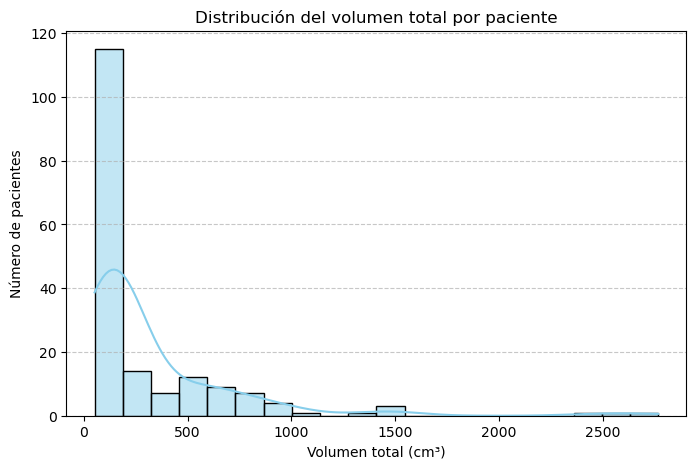

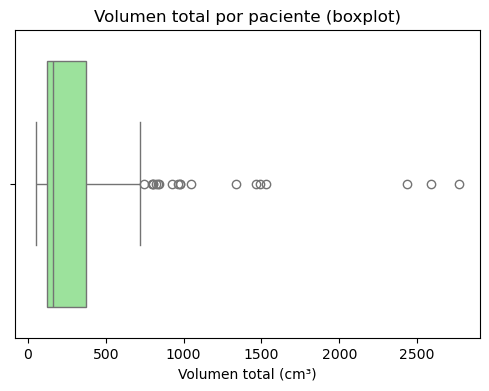

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
# Histograma de volúmenes
plt.figure(figsize=(8,5))
sns.histplot(volumen_por_paciente / 1000, bins=20, kde=True, color='skyblue')  # dividimos entre 1000 para pasar de mm³ a cm³
plt.title('Distribución del volumen total por paciente')
plt.xlabel('Volumen total (cm³)')
plt.ylabel('Número de pacientes')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Boxplot para ver dispersión y posibles outliers
plt.figure(figsize=(6,4))
sns.boxplot(x=volumen_por_paciente / 1000, color='lightgreen')
plt.title('Volumen total por paciente (boxplot)')
plt.xlabel('Volumen total (cm³)')
plt.show()

<font color='red'>RESPONDA ACA LA PREGUNTA 2.4</font>



<font color='red'>RESPONDA ACA LA PREGUNTA 2.4</font>
No todos los volumenes tienen el mismo tamaño, ya que existen diferencias en los tamaños de matriz, representado en una significativa dispersion de filas y columnas, ademas de gran variabilidad en el espesor de corte, con imagens de baja resolucion y otras de alta. Incluso valores faltantes en valores de espaciado y mAmp.

#### PREGUNTA 2.5
Lea las imágenes de la carpeta test/ y cambie los tamaños de cada una de ellas a 256x256 y guardelas en formato .png, dentro de una nueva carpeta llamada test_png/XXX/, donde XXX corresponde a la subcarpeta cuyo nombre es el ID del paciente. En esta pregunta no debe hacer un grafico.

In [43]:
#  Se debe usar ruta a drive donde tenemos carpeta test

import os
import pydicom
from PIL import Image
import numpy as np

# 1 Leemos archivos al interior de test

path = 'Datos/test'
files = os.listdir(path)
print(files)

#–––––––––––––––––––––––––––––––––––––––––––––––––––––

# 2 Para leer las subcarpetas de test

folder = "Datos/test"

# Lista las subcarpetas
subfolders = os.listdir(folder)

# Toma la primera subcarpeta
first_patient = subfolders[0]

# Construye la ruta usando concatenación
patient_path = folder + '/' + first_patient

# Crea lista los archivos dentro de esa carpeta
files = os.listdir(patient_path)

print("Primer paciente:", first_patient)
print("Archivos encontrados:", files)
len(files)

#-----------------------------------------------------

#3

# Crear carpeta principal de salida si no existe
if "test_png" not in os.listdir():
    os.mkdir("test_png")

subfolders = os.listdir(folder)

for sub in subfolders:
    patient_path = folder + "/" + sub
    if os.path.isdir(patient_path):
        out_dir = "test_png/" + sub

        # Crear carpeta del paciente si no existe
        if sub not in os.listdir("test_png"):
            os.mkdir(out_dir)

        for f in os.listdir(patient_path):
            if f.endswith(".dcm"):
                try:
                    ds = pydicom.dcmread(patient_path + "/" + f)
                    img = ds.pixel_array
                    img = (np.maximum(img, 0) / img.max()) * 255
                    img = np.uint8(img)

                    im = Image.fromarray(img).convert("L")
                    im = im.resize((256, 256))
                    im.save(out_dir + "/" + f.replace(".dcm", ".png"))
                except:
                    pass

print("Listo. Imágenes guardadas en test_png/")


['ID00423637202312137826377', 'ID00422637202311677017371', 'ID00421637202311550012437', 'ID00419637202311204720264', 'ID00426637202313170790466']
Primer paciente: ID00423637202312137826377
Archivos encontrados: ['271.dcm', '195.dcm', '24.dcm', '286.dcm', '100.dcm', '276.dcm', '268.dcm', '43.dcm', '283.dcm', '53.dcm', '197.dcm', '250.dcm', '225.dcm', '126.dcm', '39.dcm', '176.dcm', '123.dcm', '112.dcm', '175.dcm', '95.dcm', '78.dcm', '278.dcm', '187.dcm', '177.dcm', '68.dcm', '159.dcm', '16.dcm', '232.dcm', '141.dcm', '282.dcm', '93.dcm', '172.dcm', '66.dcm', '234.dcm', '210.dcm', '174.dcm', '117.dcm', '189.dcm', '240.dcm', '22.dcm', '101.dcm', '130.dcm', '137.dcm', '21.dcm', '181.dcm', '193.dcm', '169.dcm', '138.dcm', '90.dcm', '134.dcm', '104.dcm', '273.dcm', '55.dcm', '200.dcm', '170.dcm', '135.dcm', '263.dcm', '72.dcm', '81.dcm', '281.dcm', '204.dcm', '179.dcm', '139.dcm', '237.dcm', '228.dcm', '41.dcm', '121.dcm', '102.dcm', '84.dcm', '264.dcm', '148.dcm', '18.dcm', '191.dcm', '183

3. **Combinación de datos (10% de la nota final).**

Genere un dataframe combinado entre `base_de_datos` y `base_de_imagenes`.


In [44]:
# <CODE> genere un codigo que permita analizar la pregunta.
df_combinado = pd.merge(base_de_datos, base_de_imagenes,
                        left_on='Paciente', right_on='Patient', how='inner')


# Ver las primeras filas
df_combinado.head()

,Paciente,Semanas,FVC,Porcentaje,Edad,Sexo,Historial_Tabaquismo,Patient,Carpeta,Rows,...,PixelSpacing_0,PixelSpacing_1,SpacingBetweenSlices,SliceThickness,Manufacturer,KVP,XRayTubeCurrent,GeneratorPower,SliceSpacing,Vol_slice
0,ID00007637202177411956430,-4,2315,58.253649,79,Masculino,Ex fumador,ID00007637202177411956430,Datos/train/ID00007637202177411956430,512,...,0.652344,0.652344,NaN,1.25,GE MEDICAL SYSTEMS,120.0,79.0,9600.0,1.25,139445.10688
1,ID00007637202177411956430,5,2214,55.712129,79,Masculino,Ex fumador,ID00007637202177411956430,Datos/train/ID00007637202177411956430,512,...,0.652344,0.652344,NaN,1.25,GE MEDICAL SYSTEMS,120.0,79.0,9600.0,1.25,139445.10688
2,ID00007637202177411956430,7,2061,51.862104,79,Masculino,Ex fumador,ID00007637202177411956430,Datos/train/ID00007637202177411956430,512,...,0.652344,0.652344,NaN,1.25,GE MEDICAL SYSTEMS,120.0,79.0,9600.0,1.25,139445.10688
3,ID00007637202177411956430,9,2144,53.950679,79,Masculino,Ex fumador,ID00007637202177411956430,Datos/train/ID00007637202177411956430,512,...,0.652344,0.652344,NaN,1.25,GE MEDICAL SYSTEMS,120.0,79.0,9600.0,1.25,139445.10688
4,ID00007637202177411956430,11,2069,52.063412,79,Masculino,Ex fumador,ID00007637202177411956430,Datos/train/ID00007637202177411956430,512,...,0.652344,0.652344,NaN,1.25,GE MEDICAL SYSTEMS,120.0,79.0,9600.0,1.25,139445.10688


In [47]:
df_combinado = base_de_datos.merge(base_de_imagenes, on='Patient')
df_combinado.head()


KeyError: 'Patient'

In [48]:
df_combinado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1549 entries, 0 to 1548
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Paciente              1549 non-null   object 
 1   Semanas               1549 non-null   int64  
 2   FVC                   1549 non-null   int64  
 3   Porcentaje            1549 non-null   float64
 4   Edad                  1549 non-null   int64  
 5   Sexo                  1549 non-null   object 
 6   Historial_Tabaquismo  1549 non-null   object 
 7   Patient               1549 non-null   object 
 8   Carpeta               1549 non-null   object 
 9   Rows                  1549 non-null   int64  
 10  Columns               1549 non-null   int64  
 11  Num_files             1549 non-null   int64  
 12  PixelSpacing_0        1549 non-null   float64
 13  PixelSpacing_1        1549 non-null   float64
 14  SpacingBetweenSlices  370 non-null    float64
 15  SliceThickness       

In [49]:
agrupado_por_pcte = df_combinado.groupby('Paciente')
agrupado_por_pcte.describe()


Semanas                                          \
                            count       mean        std   min   25%   50%   
Paciente                                                                    
ID00007637202177411956430     9.0  19.111111  19.573224  -4.0   7.0  11.0   
ID00009637202177434476278     9.0  24.000000  18.282505   8.0  11.0  15.0   
ID00010637202177584971671     9.0  16.111111  18.797902   0.0   3.0   7.0   
ID00011637202177653955184     9.0  22.000000  18.364368   6.0   9.0  13.0   
ID00012637202177665765362     9.0  49.777778  18.599582  33.0  37.0  41.0   
...                           ...        ...        ...   ...   ...   ...   
ID00419637202311204720264     9.0  21.777778  18.646567   6.0   9.0  13.0   
ID00421637202311550012437    10.0  35.900000  21.589349  15.0  19.5  26.0   
ID00422637202311677017371     8.0  20.875000  13.715867   6.0  12.5  16.0   
ID00423637202312137826377     9.0  32.555556  18.635390  17.0  19.0  23.0   
ID00426637202313170790466     9.0  21.333333  19.287302   0.0   9.0  13.0   

                                         FVC               ... SliceSpacing  \
                             75%   max count         mean  ...          75%   
Paciente                                                   ...                
ID00007637202177411956430  29.00  57.0   9.0  2113.888889  ...         1.25   
ID00009637202177434476278  33.00  60.0   9.0  3596.666667  ...         1.25   
ID00010637202177584971671  25.00  54.0   9.0  3037.111111  ...         2.00   
ID00011637202177653955184  32.00  58.0   9.0  3387.000000  ...         1.00   
ID00012637202177665765362  58.00  87.0   9.0  3348.777778  ...         7.00   
...                          ...   ...   ...          ...  ...          ...   
ID00419637202311204720264  31.00  59.0   9.0  2782.333333  ...         1.25   
ID00421637202311550012437  50.75  70.0  10.0  2759.000000  ...         1.00   
ID00422637202311677017371  26.00  47.0   8.0  1885.875000  ...         5.00   
ID00423637202312137826377  42.00  70.0   9.0  2750.000000  ...         1.00   
ID00426637202313170790466  31.00  59.0   9.0  2896.333333  ...         0.70   

                                Vol_slice                               \
                            max     count           mean           std   
Paciente                                                                 
ID00007637202177411956430  1.25       9.0  139445.106880  0.000000e+00   
ID00009637202177434476278  1.25       9.0  174844.880320  0.000000e+00   
ID00010637202177584971671  2.00       9.0  224450.000000  0.000000e+00   
ID00011637202177653955184  1.00       9.0   88209.000000  0.000000e+00   
ID00012637202177665765362  7.00       9.0  716800.000000  0.000000e+00   
...                         ...       ...            ...           ...   
ID00419637202311204720264  1.25       9.0  821625.280137  1.234771e-10   
ID00421637202311550012437  1.00      10.0  101761.204160  0.000000e+00   
ID00422637202311677017371  5.00       8.0  577999.129600  1.244532e-10   
ID00423637202312137826377  1.00       9.0  126025.000000  0.000000e+00   
ID00426637202313170790466  0.70       9.0   94796.800000  0.000000e+00   

                                                                        \
                                     min            25%            50%   
Paciente                                                                 
ID00007637202177411956430  139445.106880  139445.106880  139445.106880   
ID00009637202177434476278  174844.880320  174844.880320  174844.880320   
ID00010637202177584971671  224450.000000  224450.000000  224450.000000   
ID00011637202177653955184   88209.000000   88209.000000   88209.000000   
ID00012637202177665765362  716800.000000  716800.000000  716800.000000   
...                                  ...            ...            ...   
ID00419637202311204720264  821625.280137  821625.280137  821625.280137   
ID00421637202311550012437  101761.204160  101761.204160  101761